## Predicting who would've survived the Titanic?

This notebook goes through a basic exploratory data analysis of the Kaggle Titanic dataset with Python

### Step 1: Download the data

You can download the data for this notebook here: https://www.kaggle.com/c/titanic/data

### Step 2: Work through the notebook
First we will import all the relevant dependencies we need.

In [1]:
# Import dependencies
%matplotlib inline

# Start python imports
import math, time, random, datetime

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be antagonist and ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Loading in the data

After we've downloaded the data, we need to get it into the notebook.

In [2]:
# Import train & test data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv') # example of what a submission should look like

In [3]:
# View the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(train)

891

In [5]:
# View the test data (Same columns as the training data)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
len(test)

418

In [7]:
# View the example submission dataframe
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## What missing values are there?

Where are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


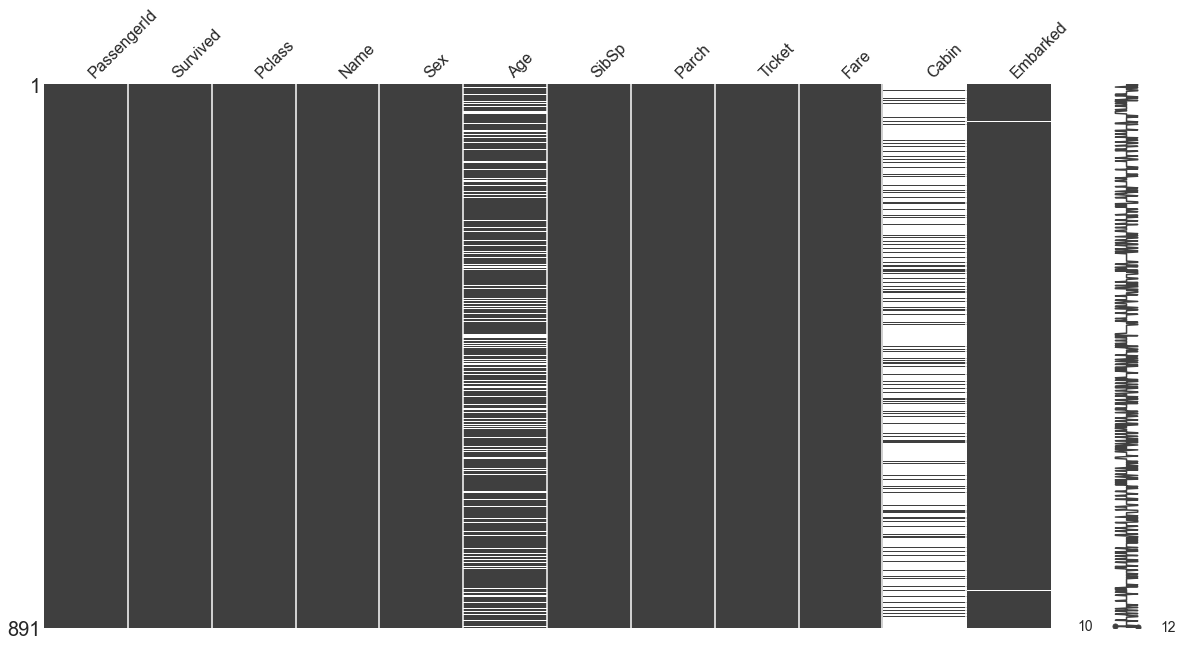

In [10]:
# Plot graphics of missing values
missingno.matrix(train, figsize = (20,10));



Ok we can clearly see some missing values here. Especially in the cabin column.

It's important to visualise missing values early so you know where the major holes are in your dataset.

Knowing this informaiton will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.


In [11]:
# Alternatively, you can see the number of missing values like this
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
# Let's write a small function to show us how many missing values there are
def find_missing_values(df, columns):
    """
    Find number of row where certain columns are missing values.
    """
    
    missing_values = {}
    print('Number of missing or NaN values for each column:')
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_values[column] = df_length - total_column_values
    return missing_values
    
missing_values = find_missing_values(train, columns= train.columns)
missing_values

Number of missing or NaN values for each column:


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

## To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [14]:
df_bin = pd.DataFrame() # for discretised continous varaibale 
df_con = pd.DataFrame() # for continuous variables

## What datatypes are in the dataframe?

As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or ints (numbers) could be considered numerical features.

However, as we dig deeper, we might find features which are numerical may actually be categorical.

The goal for the next few steps is to figure out how best to process the data so our machine learning model can learn from it.

Ideally, all the features will be encoded into a numerical value of some kind.

In [15]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually

We'll go through each column iteratively and see which ones to use in our first models. Some may need more preprocessing than others to get ready.


In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Target Feature: Survived

Description: Whether the passenger survived or not.

Key: 0 = did not survive, 1 = survived

This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


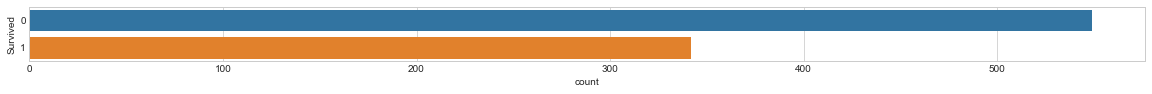

In [17]:
# How many people survived?
fig = plt.figure(figsize = (20,1))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [18]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [19]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [20]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


## Feature: Pclass

Description: The ticket class of the passenger.

Key: 1 = 1st, 2 = 2nd, 3 = 3rd

### Let's plot the distribution

We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.


<AxesSubplot:xlabel='Pclass', ylabel='Density'>

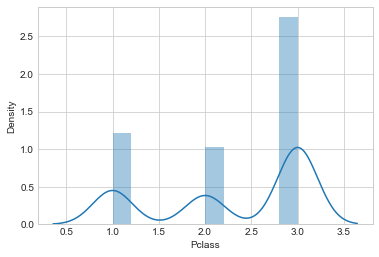

In [21]:
sns.distplot(train.Pclass)

In [22]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

Since there are no missing values in Pclass, let's add it to our sub dataframes.

In [23]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [24]:
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [25]:
df_con.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


## Feature: Name

Description: The name of the passenger.

In [26]:
# How many different names are there?
train.Name.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

Every row has a unique name. This is equivalent to the passenger ID. But name could be used differently.

Can you think of ways you could reduce the number of different names? Or create new features out of the names?

Note: Because of so many different names and to keep this EDA fast, we won't move forward using the name variable.

## Feature: Sex

Description: The sex of the passenger (male or female).

male      577
female    314
Name: Sex, dtype: int64


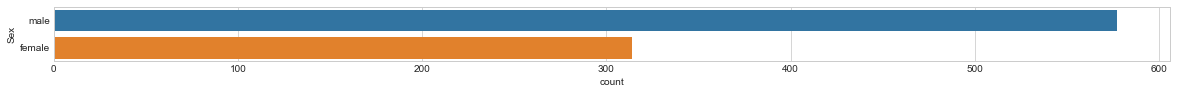

In [27]:
# Let's view the distribution of Sex
fig = plt.figure(figsize = (20,1))
sns.countplot(y='Sex', data=train)
print(train.Sex.value_counts())

In [28]:
# How many missing variables does Sex have?
train.Sex.isnull().sum()

0

Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [29]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [30]:
# Add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change Sex to 0 for male and 1 for female
df_con['Sex'] = train['Sex']
df_con['Sex'] = np.where(df_con['Sex'] == 'female', 1, 0)

In [31]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


In [32]:
df_con.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


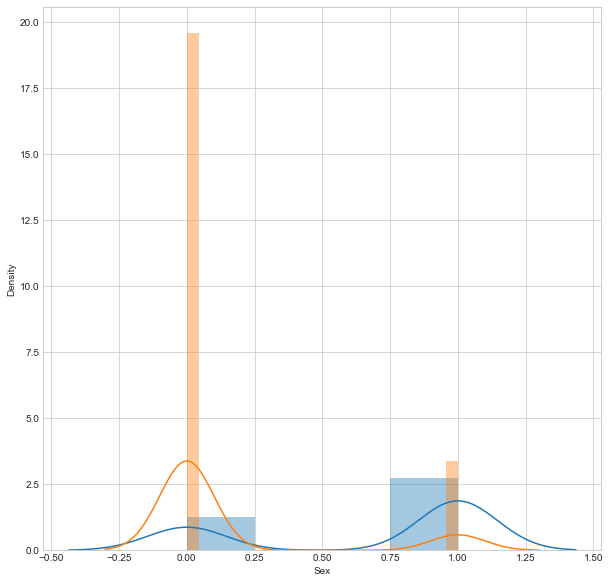

In [33]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

Not many people survived. But of those who did, more were female.

## Feature: Age

Description: The age of the passenger.

In [34]:
# How many missing values does age have?
train.Age.isnull().sum()

177



Out of a total 891 rows, that's almost one quarter of the dataset.

What would you do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or would you get rid of them completely?

We won't answer these questions in our initial EDA but this is something we would definitely revisit at a later date.


Function to create count and distribution visualisations

In [35]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});


## Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.


In [36]:
# How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [37]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Let's add SibSp to our subset dataframes and view the distributions.

In [38]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

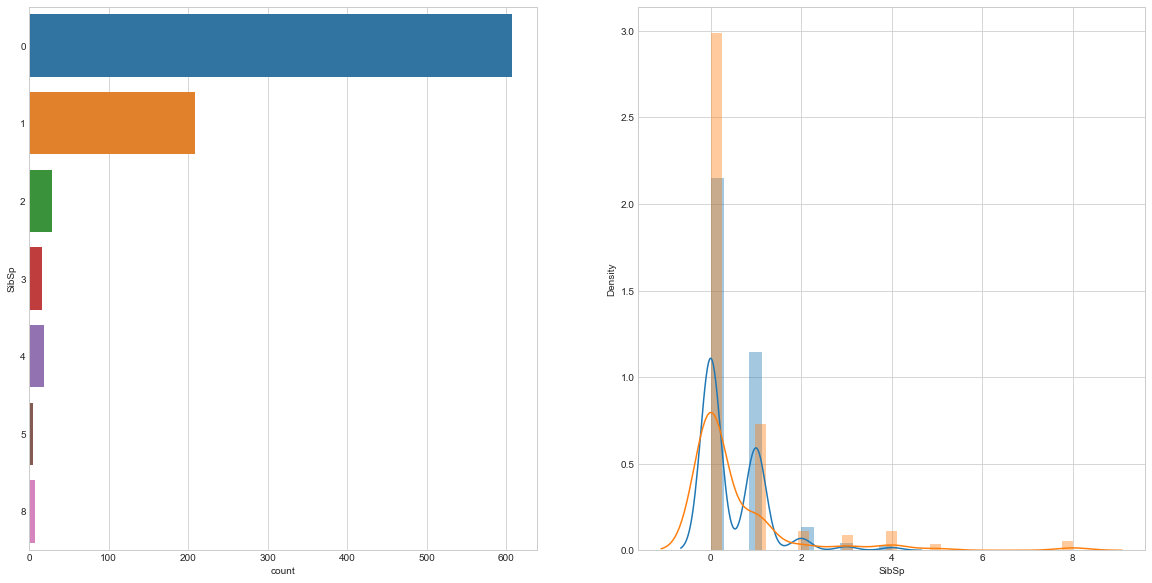

In [39]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

## Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.


In [40]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [41]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [42]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

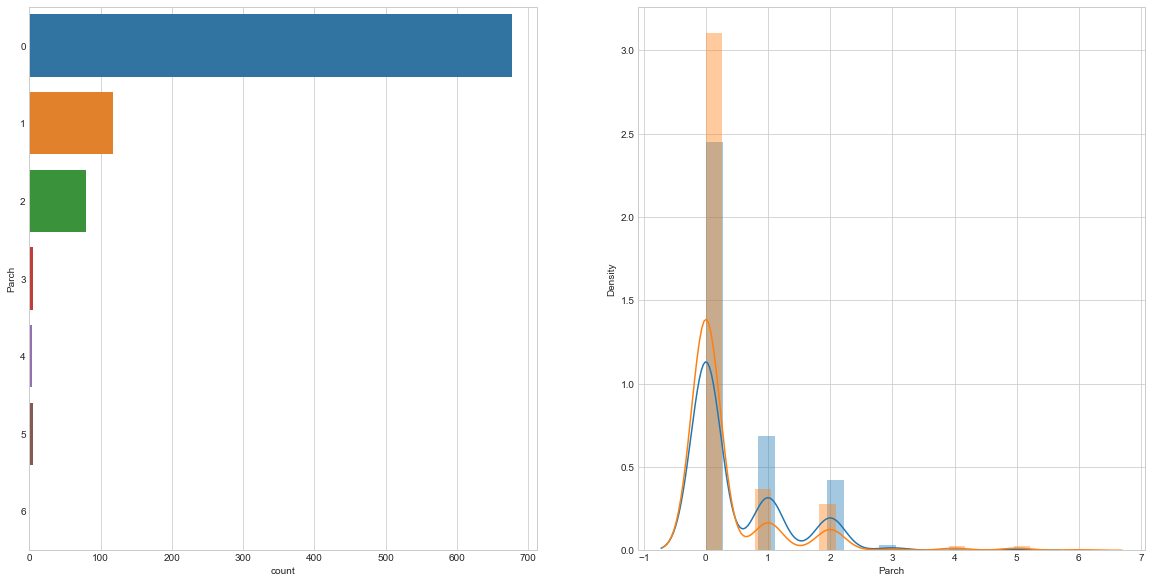

In [43]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

In [44]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,0,1,0
1,1,1,1,1,0
2,1,3,1,0,0
3,1,1,1,1,0
4,0,3,0,0,0


## Feature: Ticket

Description: The ticket number of the boarding passenger

In [46]:
# How many missing values does Ticket have?
train.Ticket.isnull().sum()

0

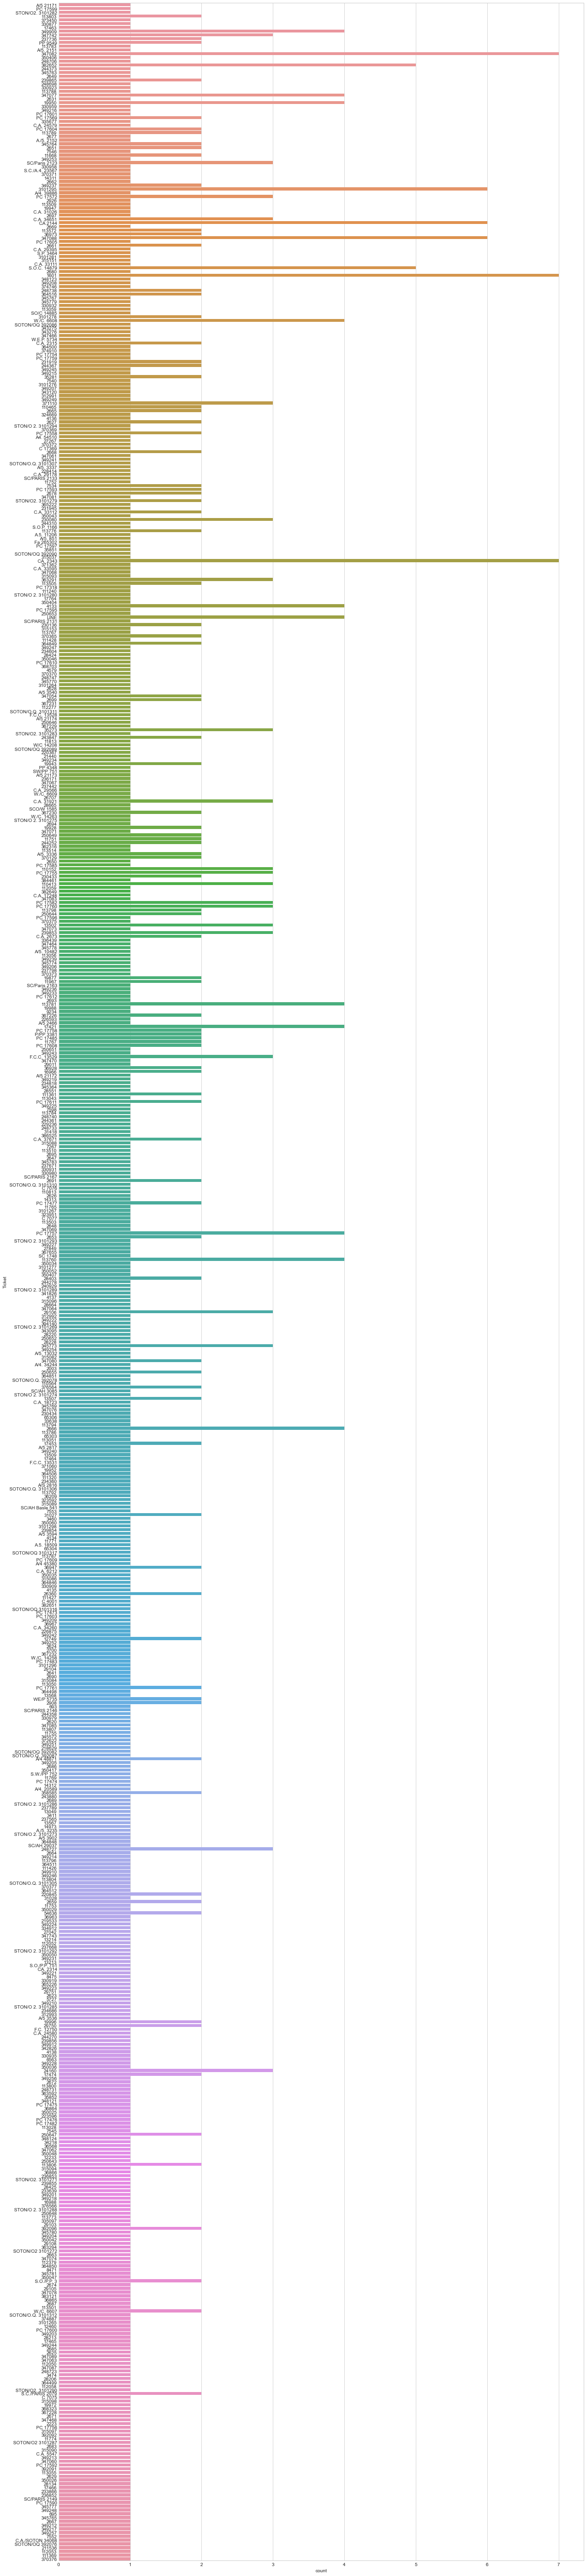

In [47]:
# How many kinds of ticket are there?
fig = plt.figure(figsize = (20,100))
sns.countplot(y="Ticket", data=train);

In [48]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [49]:
# How many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


681 unique values is too many for now. So we won't use Ticket in our subset dataframes.

There may be some way to reduce this down.

## Feature: Fare

Description: How much the ticket cost.

In [50]:
# How many missing values does Fare have?
train.Fare.isnull().sum()

0

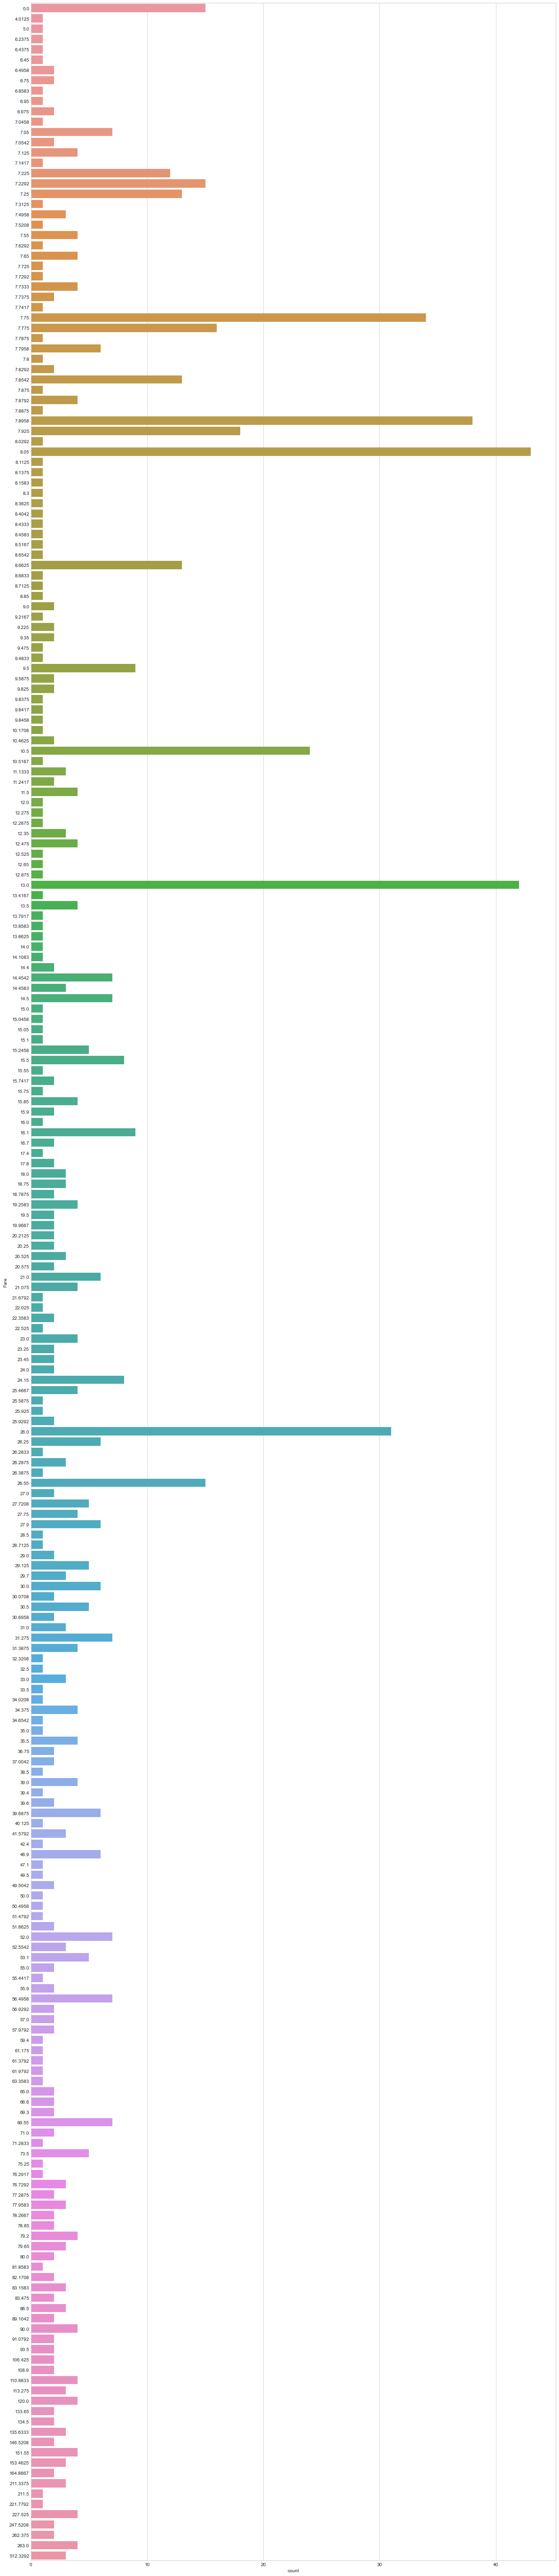

In [51]:
# How many different values of Fare are there?
fig = plt.figure(figsize = (20,100))
sns.countplot(y="Fare", data=train);

In [52]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [53]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins

In [54]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [55]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

In [56]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,7.2500
1,1,1,1,1,0,71.2833
2,1,3,1,0,0,7.9250
3,1,1,1,1,0,53.1000
4,0,3,0,0,0,8.0500


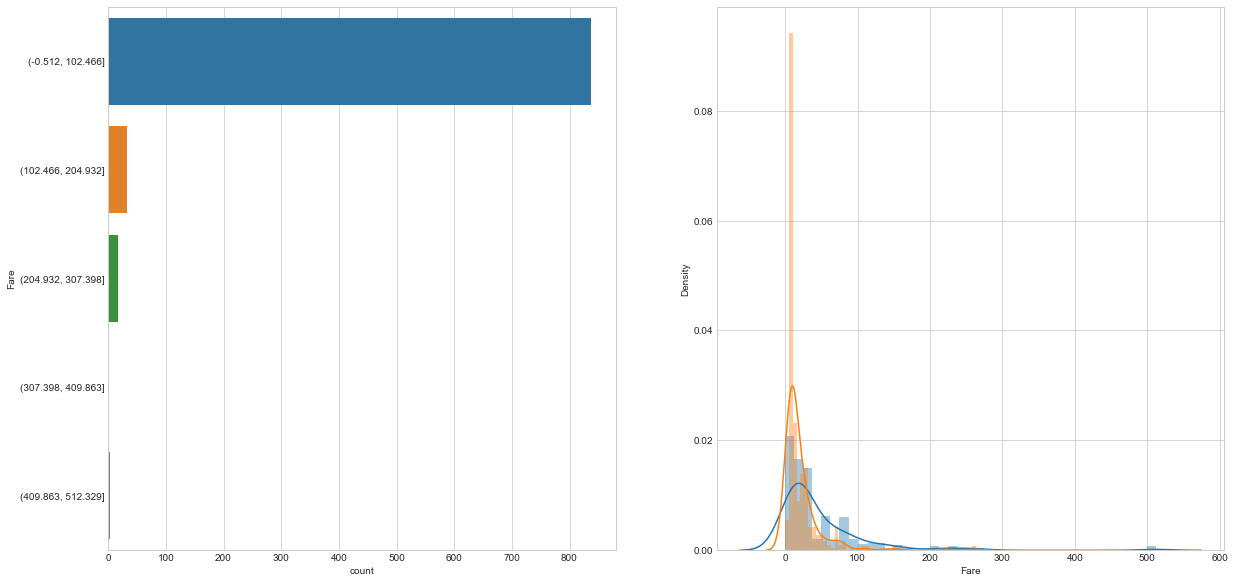

In [57]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

## Feature: Cabin

Description: The cabin number where the passenger was staying.

In [58]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [59]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [60]:
# What do the Cabin values look like?
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

## Feature: Embarked

Description: The port where the passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [61]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [62]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

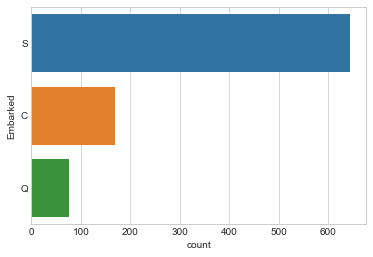

In [63]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

How can we deal with the 2 missing values of Embarked?

One option is to drop the two rows which don't have an Embarked value.

Another option would be to randomly assign a value of C, Q or S to each row.

In [64]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [65]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

## Feature Encoding

Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe `(df_bin)` with one-hot encoding and our continuous dataframe `(df_con)` with the label encoding function from `sklearn`

In [66]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [78]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [80]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,7.2500,S
1,1,1,1,1,0,71.2833,C
2,1,3,1,0,0,7.9250,S
3,1,1,1,1,0,53.1000,S
4,0,3,0,0,0,8.0500,S


In [81]:
df_con['Sex'] = np.where(df_con['Sex'] == 1, 'female', 'male')

In [82]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [83]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [84]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [96]:
# Let's look at df_con_enc
df_con_enc.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


## Start Building Machine Learning Models

Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

## Let's seperate the data

In [97]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [98]:
selected_df.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [99]:
# Split the dataframe into data and labels
x_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [100]:
# Shape of the data (without labels)
x_train.shape

(889, 11)

In [101]:
x_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [102]:
# Shape of the labels
y_train.shape

(889,)

### Define a function to fit machine learning algorithms

Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [103]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

## Logistic Regression

In [104]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               x_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:03.076793


## K-Nearest Neighbours

In [105]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  x_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 80.2
Accuracy CV 10-Fold: 75.59
Running Time: 0:00:00.139571


## Gaussian Naive Bayes

In [106]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      x_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.043409


## Linear Support Vector Machines (SVC)

In [107]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                x_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.29
Accuracy CV 10-Fold: 76.15
Running Time: 0:00:00.129174


## Stochastic Gradient Descent

In [108]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  x_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 75.03
Accuracy CV 10-Fold: 71.09
Running Time: 0:00:00.046017


## Decision Tree Classifier

In [109]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                x_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.54
Running Time: 0:00:00.078861


## Gradient Boost Trees

In [110]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       x_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:00.376508


## CatBoost Algorithm

CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the CatBoost docs.

In [111]:
# View the data for the CatBoost model
x_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [112]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [113]:
# Define the categorical features for the CatBoost model
cat_features = np.where(x_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [114]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(x_train, 
                  y_train,
                  cat_features)

In [115]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [116]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(x_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6862830	total: 205ms	remaining: 3m 25s
1:	learn: 0.6809444	total: 234ms	remaining: 1m 56s
2:	learn: 0.6751692	total: 254ms	remaining: 1m 24s
3:	learn: 0.6689060	total: 273ms	remaining: 1m 7s
4:	learn: 0.6632144	total: 290ms	remaining: 57.7s
5:	learn: 0.6576488	total: 304ms	remaining: 50.3s
6:	learn: 0.6544441	total: 310ms	remaining: 44s
7:	learn: 0.6490635	total: 327ms	remaining: 40.5s
8:	learn: 0.6443241	total: 344ms	remaining: 37.8s
9:	learn: 0.6395935	total: 360ms	remaining: 35.6s
10:	learn: 0.6345186	total: 374ms	remaining: 33.6s
11:	learn: 0.6305316	total: 390ms	remaining: 32.1s
12:	learn: 0.6275610	total: 400ms	remaining: 30.4s
13:	learn: 0.6225020	total: 420ms	remaining: 29.6s
14:	learn: 0.6179503	total: 438ms	remaining: 28.8s
15:	learn: 0.6140480	total: 447ms	remaining: 27.5s
16:	learn: 0.6100034	total: 461ms	remaining: 26.7s
17:	learn: 0.6049646	total: 477ms	remaining: 26s
18:	learn: 0.6025760	total: 484ms	remaining: 25s
19:	learn: 0.5

166:	learn: 0.4226186	total: 3.07s	remaining: 15.3s
167:	learn: 0.4222141	total: 3.09s	remaining: 15.3s
168:	learn: 0.4219366	total: 3.12s	remaining: 15.3s
169:	learn: 0.4216245	total: 3.13s	remaining: 15.3s
170:	learn: 0.4213900	total: 3.15s	remaining: 15.3s
171:	learn: 0.4210836	total: 3.17s	remaining: 15.3s
172:	learn: 0.4208199	total: 3.19s	remaining: 15.2s
173:	learn: 0.4206421	total: 3.21s	remaining: 15.2s
174:	learn: 0.4201114	total: 3.23s	remaining: 15.2s
175:	learn: 0.4198212	total: 3.24s	remaining: 15.2s
176:	learn: 0.4195834	total: 3.26s	remaining: 15.2s
177:	learn: 0.4195685	total: 3.27s	remaining: 15.1s
178:	learn: 0.4194809	total: 3.28s	remaining: 15s
179:	learn: 0.4191368	total: 3.29s	remaining: 15s
180:	learn: 0.4185960	total: 3.32s	remaining: 15s
181:	learn: 0.4184559	total: 3.33s	remaining: 15s
182:	learn: 0.4180542	total: 3.35s	remaining: 15s
183:	learn: 0.4178579	total: 3.37s	remaining: 15s
184:	learn: 0.4175684	total: 3.39s	remaining: 14.9s
185:	learn: 0.4173356	to

334:	learn: 0.3917635	total: 5.9s	remaining: 11.7s
335:	learn: 0.3916127	total: 5.92s	remaining: 11.7s
336:	learn: 0.3914735	total: 5.94s	remaining: 11.7s
337:	learn: 0.3914486	total: 5.96s	remaining: 11.7s
338:	learn: 0.3912764	total: 5.97s	remaining: 11.6s
339:	learn: 0.3911365	total: 5.99s	remaining: 11.6s
340:	learn: 0.3910828	total: 6.01s	remaining: 11.6s
341:	learn: 0.3910413	total: 6.03s	remaining: 11.6s
342:	learn: 0.3910351	total: 6.04s	remaining: 11.6s
343:	learn: 0.3908388	total: 6.05s	remaining: 11.5s
344:	learn: 0.3907468	total: 6.07s	remaining: 11.5s
345:	learn: 0.3905556	total: 6.08s	remaining: 11.5s
346:	learn: 0.3905329	total: 6.11s	remaining: 11.5s
347:	learn: 0.3904624	total: 6.12s	remaining: 11.5s
348:	learn: 0.3904620	total: 6.13s	remaining: 11.4s
349:	learn: 0.3901004	total: 6.14s	remaining: 11.4s
350:	learn: 0.3900990	total: 6.15s	remaining: 11.4s
351:	learn: 0.3898423	total: 6.17s	remaining: 11.4s
352:	learn: 0.3898011	total: 6.18s	remaining: 11.3s
353:	learn: 0

500:	learn: 0.3768153	total: 8.57s	remaining: 8.54s
501:	learn: 0.3767849	total: 8.59s	remaining: 8.52s
502:	learn: 0.3765500	total: 8.61s	remaining: 8.51s
503:	learn: 0.3763980	total: 8.63s	remaining: 8.49s
504:	learn: 0.3763692	total: 8.64s	remaining: 8.47s
505:	learn: 0.3763085	total: 8.66s	remaining: 8.46s
506:	learn: 0.3761631	total: 8.68s	remaining: 8.44s
507:	learn: 0.3760934	total: 8.69s	remaining: 8.42s
508:	learn: 0.3760498	total: 8.71s	remaining: 8.4s
509:	learn: 0.3760150	total: 8.73s	remaining: 8.38s
510:	learn: 0.3759970	total: 8.74s	remaining: 8.37s
511:	learn: 0.3759798	total: 8.76s	remaining: 8.35s
512:	learn: 0.3759568	total: 8.78s	remaining: 8.33s
513:	learn: 0.3758344	total: 8.8s	remaining: 8.32s
514:	learn: 0.3757406	total: 8.81s	remaining: 8.3s
515:	learn: 0.3757113	total: 8.83s	remaining: 8.28s
516:	learn: 0.3755908	total: 8.85s	remaining: 8.27s
517:	learn: 0.3755538	total: 8.86s	remaining: 8.25s
518:	learn: 0.3753678	total: 8.88s	remaining: 8.23s
519:	learn: 0.3

662:	learn: 0.3640602	total: 11.2s	remaining: 5.7s
663:	learn: 0.3639463	total: 11.2s	remaining: 5.69s
664:	learn: 0.3639302	total: 11.3s	remaining: 5.67s
665:	learn: 0.3638903	total: 11.3s	remaining: 5.65s
666:	learn: 0.3637239	total: 11.3s	remaining: 5.63s
667:	learn: 0.3635881	total: 11.3s	remaining: 5.62s
668:	learn: 0.3634772	total: 11.3s	remaining: 5.6s
669:	learn: 0.3634068	total: 11.3s	remaining: 5.58s
670:	learn: 0.3633759	total: 11.4s	remaining: 5.57s
671:	learn: 0.3631802	total: 11.4s	remaining: 5.55s
672:	learn: 0.3631026	total: 11.4s	remaining: 5.53s
673:	learn: 0.3630056	total: 11.4s	remaining: 5.51s
674:	learn: 0.3628564	total: 11.4s	remaining: 5.5s
675:	learn: 0.3628277	total: 11.4s	remaining: 5.48s
676:	learn: 0.3628277	total: 11.4s	remaining: 5.46s
677:	learn: 0.3627016	total: 11.5s	remaining: 5.45s
678:	learn: 0.3626910	total: 11.5s	remaining: 5.43s
679:	learn: 0.3624607	total: 11.5s	remaining: 5.41s
680:	learn: 0.3623905	total: 11.5s	remaining: 5.4s
681:	learn: 0.36

829:	learn: 0.3525719	total: 13.8s	remaining: 2.83s
830:	learn: 0.3523327	total: 13.8s	remaining: 2.81s
831:	learn: 0.3523023	total: 13.8s	remaining: 2.79s
832:	learn: 0.3522949	total: 13.9s	remaining: 2.78s
833:	learn: 0.3521358	total: 13.9s	remaining: 2.76s
834:	learn: 0.3521053	total: 13.9s	remaining: 2.74s
835:	learn: 0.3520985	total: 13.9s	remaining: 2.73s
836:	learn: 0.3520746	total: 13.9s	remaining: 2.71s
837:	learn: 0.3519963	total: 13.9s	remaining: 2.69s
838:	learn: 0.3519587	total: 13.9s	remaining: 2.68s
839:	learn: 0.3518946	total: 14s	remaining: 2.66s
840:	learn: 0.3518871	total: 14s	remaining: 2.64s
841:	learn: 0.3518257	total: 14s	remaining: 2.63s
842:	learn: 0.3518257	total: 14s	remaining: 2.61s
843:	learn: 0.3516969	total: 14s	remaining: 2.59s
844:	learn: 0.3516134	total: 14s	remaining: 2.58s
845:	learn: 0.3515626	total: 14.1s	remaining: 2.56s
846:	learn: 0.3513883	total: 14.1s	remaining: 2.54s
847:	learn: 0.3512275	total: 14.1s	remaining: 2.53s
848:	learn: 0.3512070	to

991:	learn: 0.3403515	total: 16.5s	remaining: 133ms
992:	learn: 0.3402624	total: 16.5s	remaining: 116ms
993:	learn: 0.3402175	total: 16.5s	remaining: 99.7ms
994:	learn: 0.3399939	total: 16.5s	remaining: 83.1ms
995:	learn: 0.3399342	total: 16.6s	remaining: 66.5ms
996:	learn: 0.3398669	total: 16.6s	remaining: 49.9ms
997:	learn: 0.3398219	total: 16.6s	remaining: 33.2ms
998:	learn: 0.3397748	total: 16.6s	remaining: 16.6ms
999:	learn: 0.3396214	total: 16.6s	remaining: 0us


## Perform CatBoost cross-validation

In [117]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.6745162	test: 0.6767086	best: 0.6767086 (0)	total: 18ms	remaining: 17.9s
1:	learn: 0.6563735	test: 0.6625619	best: 0.6625619 (1)	total: 35.2ms	remaining: 17.6s
2:	learn: 0.6393665	test: 0.6503586	best: 0.6503586 (2)	total: 54.1ms	remaining: 18s
3:	learn: 0.6245037	test: 0.6386039	best: 0.6386039 (3)	total: 66.6ms	remaining: 16.6s
4:	learn: 0.6100945	test: 0.6265278	best: 0.6265278 (4)	total: 83.2ms	remaining: 16.6s
5:	learn: 0.5969007	test: 0.6166952	best: 0.6166952 (5)	total: 101ms	remaining: 16.7s
6:	learn: 0.5850695	test: 0.6078388	best: 0.6078388 (6)	total: 117ms	remaining: 16.7s
7:	learn: 0.5733859	test: 0.5982216	best: 0.5982216 (7)	total: 135ms	remaining: 16.7s
8:	learn: 0.5628595	test: 0.5914378	best: 0.5914378 (8)	total: 152ms	remaining: 16.7s
9:	learn: 0.5515334	test: 0.5834997	best: 0.5834997 (9)	total: 176ms	remaining: 17.4s
10:	learn: 0.5427606	test: 0.5765989	best: 0.5765989 (10)	total: 191ms	remaining: 17.2s
11:	learn: 0.5328784	test: 

95:	learn: 0.3827909	test: 0.4890528	best: 0.4888744 (94)	total: 1.63s	remaining: 15.4s
96:	learn: 0.3826982	test: 0.4890446	best: 0.4888744 (94)	total: 1.64s	remaining: 15.3s
97:	learn: 0.3823428	test: 0.4891907	best: 0.4888744 (94)	total: 1.66s	remaining: 15.3s
98:	learn: 0.3817752	test: 0.4893643	best: 0.4888744 (94)	total: 1.68s	remaining: 15.3s
99:	learn: 0.3817701	test: 0.4893657	best: 0.4888744 (94)	total: 1.69s	remaining: 15.2s
100:	learn: 0.3812067	test: 0.4893273	best: 0.4888744 (94)	total: 1.71s	remaining: 15.2s
101:	learn: 0.3804864	test: 0.4891180	best: 0.4888744 (94)	total: 1.72s	remaining: 15.2s
102:	learn: 0.3797088	test: 0.4885391	best: 0.4885391 (102)	total: 1.74s	remaining: 15.2s
103:	learn: 0.3797015	test: 0.4885401	best: 0.4885391 (102)	total: 1.75s	remaining: 15.1s
104:	learn: 0.3783232	test: 0.4871529	best: 0.4871529 (104)	total: 1.77s	remaining: 15.1s
105:	learn: 0.3782885	test: 0.4871386	best: 0.4871386 (105)	total: 1.78s	remaining: 15s
106:	learn: 0.3779293	te

192:	learn: 0.3563873	test: 0.4851109	best: 0.4846511 (188)	total: 3.22s	remaining: 13.4s
193:	learn: 0.3560910	test: 0.4854361	best: 0.4846511 (188)	total: 3.23s	remaining: 13.4s
194:	learn: 0.3558076	test: 0.4860375	best: 0.4846511 (188)	total: 3.25s	remaining: 13.4s
195:	learn: 0.3554459	test: 0.4860785	best: 0.4846511 (188)	total: 3.27s	remaining: 13.4s
196:	learn: 0.3554277	test: 0.4861078	best: 0.4846511 (188)	total: 3.28s	remaining: 13.4s
197:	learn: 0.3551814	test: 0.4862507	best: 0.4846511 (188)	total: 3.29s	remaining: 13.3s
198:	learn: 0.3548815	test: 0.4860885	best: 0.4846511 (188)	total: 3.31s	remaining: 13.3s
199:	learn: 0.3548793	test: 0.4860890	best: 0.4846511 (188)	total: 3.32s	remaining: 13.3s
200:	learn: 0.3547621	test: 0.4860554	best: 0.4846511 (188)	total: 3.33s	remaining: 13.2s
201:	learn: 0.3543466	test: 0.4859695	best: 0.4846511 (188)	total: 3.35s	remaining: 13.2s
202:	learn: 0.3540871	test: 0.4860360	best: 0.4846511 (188)	total: 3.37s	remaining: 13.2s
203:	learn

290:	learn: 0.3323318	test: 0.4868717	best: 0.4846511 (188)	total: 4.85s	remaining: 11.8s
291:	learn: 0.3320090	test: 0.4868475	best: 0.4846511 (188)	total: 4.87s	remaining: 11.8s
292:	learn: 0.3318438	test: 0.4872850	best: 0.4846511 (188)	total: 4.89s	remaining: 11.8s
293:	learn: 0.3317316	test: 0.4872053	best: 0.4846511 (188)	total: 4.91s	remaining: 11.8s
294:	learn: 0.3313451	test: 0.4872954	best: 0.4846511 (188)	total: 4.92s	remaining: 11.8s
295:	learn: 0.3310975	test: 0.4877238	best: 0.4846511 (188)	total: 4.94s	remaining: 11.7s
296:	learn: 0.3304348	test: 0.4872788	best: 0.4846511 (188)	total: 4.96s	remaining: 11.7s
297:	learn: 0.3303330	test: 0.4873508	best: 0.4846511 (188)	total: 4.97s	remaining: 11.7s
298:	learn: 0.3300321	test: 0.4879937	best: 0.4846511 (188)	total: 4.99s	remaining: 11.7s
299:	learn: 0.3299031	test: 0.4881196	best: 0.4846511 (188)	total: 5.01s	remaining: 11.7s
300:	learn: 0.3298716	test: 0.4881434	best: 0.4846511 (188)	total: 5.03s	remaining: 11.7s
301:	learn

388:	learn: 0.3053589	test: 0.4856955	best: 0.4846511 (188)	total: 6.71s	remaining: 10.5s
389:	learn: 0.3052422	test: 0.4860075	best: 0.4846511 (188)	total: 6.73s	remaining: 10.5s
390:	learn: 0.3048362	test: 0.4862272	best: 0.4846511 (188)	total: 6.75s	remaining: 10.5s
391:	learn: 0.3048218	test: 0.4861523	best: 0.4846511 (188)	total: 6.76s	remaining: 10.5s
392:	learn: 0.3045643	test: 0.4859807	best: 0.4846511 (188)	total: 6.78s	remaining: 10.5s
393:	learn: 0.3042748	test: 0.4857216	best: 0.4846511 (188)	total: 6.8s	remaining: 10.5s
394:	learn: 0.3041282	test: 0.4859186	best: 0.4846511 (188)	total: 6.82s	remaining: 10.4s
395:	learn: 0.3039519	test: 0.4860370	best: 0.4846511 (188)	total: 6.83s	remaining: 10.4s
396:	learn: 0.3038344	test: 0.4860186	best: 0.4846511 (188)	total: 6.85s	remaining: 10.4s
397:	learn: 0.3033730	test: 0.4853184	best: 0.4846511 (188)	total: 6.87s	remaining: 10.4s
398:	learn: 0.3029848	test: 0.4853102	best: 0.4846511 (188)	total: 6.88s	remaining: 10.4s
399:	learn:

482:	learn: 0.2834032	test: 0.4847561	best: 0.4826818 (455)	total: 8.38s	remaining: 8.97s
483:	learn: 0.2832851	test: 0.4847476	best: 0.4826818 (455)	total: 8.4s	remaining: 8.96s
484:	learn: 0.2832356	test: 0.4847978	best: 0.4826818 (455)	total: 8.42s	remaining: 8.94s
485:	learn: 0.2832150	test: 0.4847602	best: 0.4826818 (455)	total: 8.44s	remaining: 8.92s
486:	learn: 0.2829620	test: 0.4849151	best: 0.4826818 (455)	total: 8.45s	remaining: 8.91s
487:	learn: 0.2824950	test: 0.4840408	best: 0.4826818 (455)	total: 8.48s	remaining: 8.89s
488:	learn: 0.2824734	test: 0.4839939	best: 0.4826818 (455)	total: 8.49s	remaining: 8.88s
489:	learn: 0.2823755	test: 0.4839713	best: 0.4826818 (455)	total: 8.51s	remaining: 8.86s
490:	learn: 0.2821873	test: 0.4838208	best: 0.4826818 (455)	total: 8.53s	remaining: 8.84s
491:	learn: 0.2817912	test: 0.4839452	best: 0.4826818 (455)	total: 8.54s	remaining: 8.82s
492:	learn: 0.2814836	test: 0.4840257	best: 0.4826818 (455)	total: 8.56s	remaining: 8.8s
493:	learn: 

583:	learn: 0.2678471	test: 0.4854835	best: 0.4826818 (455)	total: 10.2s	remaining: 7.27s
584:	learn: 0.2677019	test: 0.4854744	best: 0.4826818 (455)	total: 10.2s	remaining: 7.25s
585:	learn: 0.2676425	test: 0.4854772	best: 0.4826818 (455)	total: 10.2s	remaining: 7.23s
586:	learn: 0.2674681	test: 0.4863044	best: 0.4826818 (455)	total: 10.3s	remaining: 7.22s
587:	learn: 0.2672439	test: 0.4863223	best: 0.4826818 (455)	total: 10.3s	remaining: 7.2s
588:	learn: 0.2669453	test: 0.4864768	best: 0.4826818 (455)	total: 10.3s	remaining: 7.18s
589:	learn: 0.2668352	test: 0.4865217	best: 0.4826818 (455)	total: 10.3s	remaining: 7.16s
590:	learn: 0.2666508	test: 0.4863442	best: 0.4826818 (455)	total: 10.3s	remaining: 7.14s
591:	learn: 0.2665290	test: 0.4865648	best: 0.4826818 (455)	total: 10.3s	remaining: 7.13s
592:	learn: 0.2664344	test: 0.4866101	best: 0.4826818 (455)	total: 10.4s	remaining: 7.11s
593:	learn: 0.2663395	test: 0.4865529	best: 0.4826818 (455)	total: 10.4s	remaining: 7.09s
594:	learn:

677:	learn: 0.2531954	test: 0.4899507	best: 0.4826818 (455)	total: 11.9s	remaining: 5.64s
678:	learn: 0.2531438	test: 0.4900660	best: 0.4826818 (455)	total: 11.9s	remaining: 5.62s
679:	learn: 0.2529795	test: 0.4900964	best: 0.4826818 (455)	total: 11.9s	remaining: 5.61s
680:	learn: 0.2529536	test: 0.4901154	best: 0.4826818 (455)	total: 11.9s	remaining: 5.59s
681:	learn: 0.2529086	test: 0.4901129	best: 0.4826818 (455)	total: 11.9s	remaining: 5.57s
682:	learn: 0.2525760	test: 0.4901550	best: 0.4826818 (455)	total: 12s	remaining: 5.55s
683:	learn: 0.2524072	test: 0.4900728	best: 0.4826818 (455)	total: 12s	remaining: 5.54s
684:	learn: 0.2523855	test: 0.4900853	best: 0.4826818 (455)	total: 12s	remaining: 5.52s
685:	learn: 0.2523286	test: 0.4900132	best: 0.4826818 (455)	total: 12s	remaining: 5.5s
686:	learn: 0.2520566	test: 0.4890835	best: 0.4826818 (455)	total: 12s	remaining: 5.48s
687:	learn: 0.2519687	test: 0.4889617	best: 0.4826818 (455)	total: 12.1s	remaining: 5.46s
688:	learn: 0.2518829

780:	learn: 0.2406786	test: 0.4890738	best: 0.4826818 (455)	total: 13.8s	remaining: 3.86s
781:	learn: 0.2405871	test: 0.4890218	best: 0.4826818 (455)	total: 13.8s	remaining: 3.84s
782:	learn: 0.2403600	test: 0.4887417	best: 0.4826818 (455)	total: 13.8s	remaining: 3.82s
783:	learn: 0.2402008	test: 0.4889193	best: 0.4826818 (455)	total: 13.8s	remaining: 3.8s
784:	learn: 0.2399305	test: 0.4887337	best: 0.4826818 (455)	total: 13.8s	remaining: 3.79s
785:	learn: 0.2398575	test: 0.4887319	best: 0.4826818 (455)	total: 13.8s	remaining: 3.77s
786:	learn: 0.2397426	test: 0.4887456	best: 0.4826818 (455)	total: 13.9s	remaining: 3.75s
787:	learn: 0.2395383	test: 0.4889063	best: 0.4826818 (455)	total: 13.9s	remaining: 3.73s
788:	learn: 0.2393706	test: 0.4891079	best: 0.4826818 (455)	total: 13.9s	remaining: 3.72s
789:	learn: 0.2393370	test: 0.4890316	best: 0.4826818 (455)	total: 13.9s	remaining: 3.7s
790:	learn: 0.2391798	test: 0.4890866	best: 0.4826818 (455)	total: 13.9s	remaining: 3.68s
791:	learn: 

873:	learn: 0.2295624	test: 0.4866602	best: 0.4826818 (455)	total: 15.4s	remaining: 2.22s
874:	learn: 0.2294942	test: 0.4866252	best: 0.4826818 (455)	total: 15.4s	remaining: 2.21s
875:	learn: 0.2293574	test: 0.4866266	best: 0.4826818 (455)	total: 15.5s	remaining: 2.19s
876:	learn: 0.2293482	test: 0.4866842	best: 0.4826818 (455)	total: 15.5s	remaining: 2.17s
877:	learn: 0.2292399	test: 0.4867861	best: 0.4826818 (455)	total: 15.5s	remaining: 2.15s
878:	learn: 0.2291691	test: 0.4869274	best: 0.4826818 (455)	total: 15.5s	remaining: 2.13s
879:	learn: 0.2290961	test: 0.4868838	best: 0.4826818 (455)	total: 15.5s	remaining: 2.12s
880:	learn: 0.2290281	test: 0.4866529	best: 0.4826818 (455)	total: 15.5s	remaining: 2.1s
881:	learn: 0.2287510	test: 0.4865451	best: 0.4826818 (455)	total: 15.6s	remaining: 2.08s
882:	learn: 0.2286215	test: 0.4858748	best: 0.4826818 (455)	total: 15.6s	remaining: 2.06s
883:	learn: 0.2285106	test: 0.4858739	best: 0.4826818 (455)	total: 15.6s	remaining: 2.05s
884:	learn:

966:	learn: 0.2193572	test: 0.4842848	best: 0.4826818 (455)	total: 17.1s	remaining: 583ms
967:	learn: 0.2190903	test: 0.4843401	best: 0.4826818 (455)	total: 17.1s	remaining: 565ms
968:	learn: 0.2190178	test: 0.4845863	best: 0.4826818 (455)	total: 17.1s	remaining: 547ms
969:	learn: 0.2189363	test: 0.4845533	best: 0.4826818 (455)	total: 17.1s	remaining: 530ms
970:	learn: 0.2188412	test: 0.4846315	best: 0.4826818 (455)	total: 17.1s	remaining: 512ms
971:	learn: 0.2187657	test: 0.4850436	best: 0.4826818 (455)	total: 17.2s	remaining: 494ms
972:	learn: 0.2185642	test: 0.4852296	best: 0.4826818 (455)	total: 17.2s	remaining: 477ms
973:	learn: 0.2184607	test: 0.4853274	best: 0.4826818 (455)	total: 17.3s	remaining: 462ms
974:	learn: 0.2184487	test: 0.4854990	best: 0.4826818 (455)	total: 17.3s	remaining: 444ms
975:	learn: 0.2183717	test: 0.4854031	best: 0.4826818 (455)	total: 17.3s	remaining: 426ms
976:	learn: 0.2182619	test: 0.4854411	best: 0.4826818 (455)	total: 17.3s	remaining: 408ms
977:	learn

58:	learn: 0.4120003	test: 0.4567118	best: 0.4567118 (58)	total: 955ms	remaining: 15.2s
59:	learn: 0.4117740	test: 0.4568569	best: 0.4567118 (58)	total: 968ms	remaining: 15.2s
60:	learn: 0.4108670	test: 0.4564287	best: 0.4564287 (60)	total: 993ms	remaining: 15.3s
61:	learn: 0.4107589	test: 0.4564668	best: 0.4564287 (60)	total: 1.01s	remaining: 15.2s
62:	learn: 0.4102687	test: 0.4564165	best: 0.4564165 (62)	total: 1.02s	remaining: 15.2s
63:	learn: 0.4095216	test: 0.4566351	best: 0.4564165 (62)	total: 1.04s	remaining: 15.2s
64:	learn: 0.4094928	test: 0.4566219	best: 0.4564165 (62)	total: 1.05s	remaining: 15.1s
65:	learn: 0.4094656	test: 0.4566100	best: 0.4564165 (62)	total: 1.05s	remaining: 14.9s
66:	learn: 0.4089147	test: 0.4561993	best: 0.4561993 (66)	total: 1.06s	remaining: 14.8s
67:	learn: 0.4076138	test: 0.4559983	best: 0.4559983 (67)	total: 1.08s	remaining: 14.8s
68:	learn: 0.4070922	test: 0.4560952	best: 0.4559983 (67)	total: 1.09s	remaining: 14.8s
69:	learn: 0.4057995	test: 0.455

158:	learn: 0.3691063	test: 0.4509550	best: 0.4506053 (86)	total: 2.6s	remaining: 13.8s
159:	learn: 0.3688708	test: 0.4508896	best: 0.4506053 (86)	total: 2.62s	remaining: 13.8s
160:	learn: 0.3680776	test: 0.4495697	best: 0.4495697 (160)	total: 2.64s	remaining: 13.7s
161:	learn: 0.3680776	test: 0.4495698	best: 0.4495697 (160)	total: 2.64s	remaining: 13.7s
162:	learn: 0.3677318	test: 0.4490857	best: 0.4490857 (162)	total: 2.66s	remaining: 13.7s
163:	learn: 0.3673340	test: 0.4487888	best: 0.4487888 (163)	total: 2.68s	remaining: 13.6s
164:	learn: 0.3672985	test: 0.4487299	best: 0.4487299 (164)	total: 2.68s	remaining: 13.6s
165:	learn: 0.3672597	test: 0.4487430	best: 0.4487299 (164)	total: 2.69s	remaining: 13.5s
166:	learn: 0.3671633	test: 0.4489805	best: 0.4487299 (164)	total: 2.71s	remaining: 13.5s
167:	learn: 0.3670089	test: 0.4489336	best: 0.4487299 (164)	total: 2.73s	remaining: 13.5s
168:	learn: 0.3668032	test: 0.4487696	best: 0.4487299 (164)	total: 2.74s	remaining: 13.5s
169:	learn: 0

256:	learn: 0.3441009	test: 0.4520963	best: 0.4485396 (196)	total: 4.26s	remaining: 12.3s
257:	learn: 0.3440706	test: 0.4521103	best: 0.4485396 (196)	total: 4.27s	remaining: 12.3s
258:	learn: 0.3439721	test: 0.4523340	best: 0.4485396 (196)	total: 4.29s	remaining: 12.3s
259:	learn: 0.3433723	test: 0.4527265	best: 0.4485396 (196)	total: 4.3s	remaining: 12.3s
260:	learn: 0.3432173	test: 0.4528683	best: 0.4485396 (196)	total: 4.32s	remaining: 12.2s
261:	learn: 0.3423877	test: 0.4528939	best: 0.4485396 (196)	total: 4.34s	remaining: 12.2s
262:	learn: 0.3422036	test: 0.4530391	best: 0.4485396 (196)	total: 4.35s	remaining: 12.2s
263:	learn: 0.3421549	test: 0.4530297	best: 0.4485396 (196)	total: 4.37s	remaining: 12.2s
264:	learn: 0.3418490	test: 0.4527791	best: 0.4485396 (196)	total: 4.38s	remaining: 12.2s
265:	learn: 0.3415437	test: 0.4528171	best: 0.4485396 (196)	total: 4.4s	remaining: 12.1s
266:	learn: 0.3414496	test: 0.4527412	best: 0.4485396 (196)	total: 4.42s	remaining: 12.1s
267:	learn: 

351:	learn: 0.3187308	test: 0.4525944	best: 0.4485396 (196)	total: 5.92s	remaining: 10.9s
352:	learn: 0.3184992	test: 0.4530728	best: 0.4485396 (196)	total: 5.93s	remaining: 10.9s
353:	learn: 0.3183842	test: 0.4530523	best: 0.4485396 (196)	total: 5.95s	remaining: 10.9s
354:	learn: 0.3179099	test: 0.4526584	best: 0.4485396 (196)	total: 5.97s	remaining: 10.8s
355:	learn: 0.3178658	test: 0.4525934	best: 0.4485396 (196)	total: 5.98s	remaining: 10.8s
356:	learn: 0.3175944	test: 0.4521584	best: 0.4485396 (196)	total: 6s	remaining: 10.8s
357:	learn: 0.3173315	test: 0.4520410	best: 0.4485396 (196)	total: 6.01s	remaining: 10.8s
358:	learn: 0.3171706	test: 0.4520364	best: 0.4485396 (196)	total: 6.03s	remaining: 10.8s
359:	learn: 0.3170019	test: 0.4518772	best: 0.4485396 (196)	total: 6.05s	remaining: 10.8s
360:	learn: 0.3167300	test: 0.4522247	best: 0.4485396 (196)	total: 6.07s	remaining: 10.7s
361:	learn: 0.3164693	test: 0.4524062	best: 0.4485396 (196)	total: 6.08s	remaining: 10.7s
362:	learn: 0

453:	learn: 0.2961108	test: 0.4572960	best: 0.4485396 (196)	total: 7.76s	remaining: 9.33s
454:	learn: 0.2960119	test: 0.4572307	best: 0.4485396 (196)	total: 7.77s	remaining: 9.31s
455:	learn: 0.2959261	test: 0.4569336	best: 0.4485396 (196)	total: 7.79s	remaining: 9.29s
456:	learn: 0.2957870	test: 0.4569714	best: 0.4485396 (196)	total: 7.81s	remaining: 9.28s
457:	learn: 0.2956098	test: 0.4571312	best: 0.4485396 (196)	total: 7.83s	remaining: 9.26s
458:	learn: 0.2955378	test: 0.4570780	best: 0.4485396 (196)	total: 7.84s	remaining: 9.24s
459:	learn: 0.2950838	test: 0.4566090	best: 0.4485396 (196)	total: 7.86s	remaining: 9.23s
460:	learn: 0.2945932	test: 0.4561858	best: 0.4485396 (196)	total: 7.88s	remaining: 9.21s
461:	learn: 0.2944254	test: 0.4563065	best: 0.4485396 (196)	total: 7.89s	remaining: 9.19s
462:	learn: 0.2941923	test: 0.4564419	best: 0.4485396 (196)	total: 7.91s	remaining: 9.18s
463:	learn: 0.2940266	test: 0.4559100	best: 0.4485396 (196)	total: 7.93s	remaining: 9.16s
464:	learn

547:	learn: 0.2756875	test: 0.4607904	best: 0.4485396 (196)	total: 9.42s	remaining: 7.77s
548:	learn: 0.2756174	test: 0.4607746	best: 0.4485396 (196)	total: 9.43s	remaining: 7.75s
549:	learn: 0.2752726	test: 0.4614867	best: 0.4485396 (196)	total: 9.45s	remaining: 7.73s
550:	learn: 0.2749710	test: 0.4615210	best: 0.4485396 (196)	total: 9.47s	remaining: 7.72s
551:	learn: 0.2746468	test: 0.4622733	best: 0.4485396 (196)	total: 9.49s	remaining: 7.7s
552:	learn: 0.2743629	test: 0.4623682	best: 0.4485396 (196)	total: 9.5s	remaining: 7.68s
553:	learn: 0.2742828	test: 0.4628195	best: 0.4485396 (196)	total: 9.52s	remaining: 7.67s
554:	learn: 0.2741725	test: 0.4627994	best: 0.4485396 (196)	total: 9.54s	remaining: 7.65s
555:	learn: 0.2736724	test: 0.4627965	best: 0.4485396 (196)	total: 9.55s	remaining: 7.63s
556:	learn: 0.2735882	test: 0.4629471	best: 0.4485396 (196)	total: 9.57s	remaining: 7.61s
557:	learn: 0.2735766	test: 0.4629458	best: 0.4485396 (196)	total: 9.59s	remaining: 7.59s
558:	learn: 

650:	learn: 0.2593135	test: 0.4694614	best: 0.4485396 (196)	total: 11.3s	remaining: 6.04s
651:	learn: 0.2590480	test: 0.4697852	best: 0.4485396 (196)	total: 11.3s	remaining: 6.02s
652:	learn: 0.2589245	test: 0.4697716	best: 0.4485396 (196)	total: 11.3s	remaining: 6.01s
653:	learn: 0.2587822	test: 0.4697162	best: 0.4485396 (196)	total: 11.3s	remaining: 5.99s
654:	learn: 0.2586033	test: 0.4697229	best: 0.4485396 (196)	total: 11.3s	remaining: 5.97s
655:	learn: 0.2585988	test: 0.4697252	best: 0.4485396 (196)	total: 11.3s	remaining: 5.95s
656:	learn: 0.2583988	test: 0.4699773	best: 0.4485396 (196)	total: 11.4s	remaining: 5.93s
657:	learn: 0.2582191	test: 0.4700241	best: 0.4485396 (196)	total: 11.4s	remaining: 5.92s
658:	learn: 0.2580023	test: 0.4701491	best: 0.4485396 (196)	total: 11.4s	remaining: 5.9s
659:	learn: 0.2579097	test: 0.4700668	best: 0.4485396 (196)	total: 11.4s	remaining: 5.88s
660:	learn: 0.2578348	test: 0.4701676	best: 0.4485396 (196)	total: 11.4s	remaining: 5.86s
661:	learn:

751:	learn: 0.2444482	test: 0.4721570	best: 0.4485396 (196)	total: 13.2s	remaining: 4.35s
752:	learn: 0.2442766	test: 0.4723381	best: 0.4485396 (196)	total: 13.2s	remaining: 4.34s
753:	learn: 0.2441163	test: 0.4723566	best: 0.4485396 (196)	total: 13.2s	remaining: 4.32s
754:	learn: 0.2439973	test: 0.4722962	best: 0.4485396 (196)	total: 13.3s	remaining: 4.3s
755:	learn: 0.2438193	test: 0.4725310	best: 0.4485396 (196)	total: 13.3s	remaining: 4.29s
756:	learn: 0.2435927	test: 0.4730936	best: 0.4485396 (196)	total: 13.3s	remaining: 4.27s
757:	learn: 0.2432951	test: 0.4735473	best: 0.4485396 (196)	total: 13.3s	remaining: 4.25s
758:	learn: 0.2432607	test: 0.4735864	best: 0.4485396 (196)	total: 13.3s	remaining: 4.23s
759:	learn: 0.2431821	test: 0.4735502	best: 0.4485396 (196)	total: 13.3s	remaining: 4.21s
760:	learn: 0.2431094	test: 0.4736339	best: 0.4485396 (196)	total: 13.4s	remaining: 4.2s
761:	learn: 0.2430844	test: 0.4736236	best: 0.4485396 (196)	total: 13.4s	remaining: 4.18s
762:	learn: 

843:	learn: 0.2332005	test: 0.4803099	best: 0.4485396 (196)	total: 14.8s	remaining: 2.74s
844:	learn: 0.2326296	test: 0.4800163	best: 0.4485396 (196)	total: 14.8s	remaining: 2.72s
845:	learn: 0.2325570	test: 0.4800776	best: 0.4485396 (196)	total: 14.9s	remaining: 2.7s
846:	learn: 0.2323265	test: 0.4802320	best: 0.4485396 (196)	total: 14.9s	remaining: 2.69s
847:	learn: 0.2321324	test: 0.4798337	best: 0.4485396 (196)	total: 14.9s	remaining: 2.67s
848:	learn: 0.2320439	test: 0.4796535	best: 0.4485396 (196)	total: 14.9s	remaining: 2.65s
849:	learn: 0.2318430	test: 0.4793377	best: 0.4485396 (196)	total: 14.9s	remaining: 2.63s
850:	learn: 0.2316988	test: 0.4793126	best: 0.4485396 (196)	total: 14.9s	remaining: 2.62s
851:	learn: 0.2316734	test: 0.4794498	best: 0.4485396 (196)	total: 15s	remaining: 2.6s
852:	learn: 0.2313419	test: 0.4793964	best: 0.4485396 (196)	total: 15s	remaining: 2.59s
853:	learn: 0.2312164	test: 0.4795290	best: 0.4485396 (196)	total: 15s	remaining: 2.57s
854:	learn: 0.2310

937:	learn: 0.2229535	test: 0.4832472	best: 0.4485396 (196)	total: 16.5s	remaining: 1.09s
938:	learn: 0.2229364	test: 0.4832549	best: 0.4485396 (196)	total: 16.5s	remaining: 1.07s
939:	learn: 0.2228717	test: 0.4832744	best: 0.4485396 (196)	total: 16.5s	remaining: 1.05s
940:	learn: 0.2227586	test: 0.4833101	best: 0.4485396 (196)	total: 16.6s	remaining: 1.04s
941:	learn: 0.2226067	test: 0.4832723	best: 0.4485396 (196)	total: 16.6s	remaining: 1.02s
942:	learn: 0.2225339	test: 0.4832622	best: 0.4485396 (196)	total: 16.6s	remaining: 1s
943:	learn: 0.2224138	test: 0.4837289	best: 0.4485396 (196)	total: 16.6s	remaining: 985ms
944:	learn: 0.2223655	test: 0.4837405	best: 0.4485396 (196)	total: 16.6s	remaining: 968ms
945:	learn: 0.2222768	test: 0.4833366	best: 0.4485396 (196)	total: 16.6s	remaining: 950ms
946:	learn: 0.2221648	test: 0.4833134	best: 0.4485396 (196)	total: 16.7s	remaining: 932ms
947:	learn: 0.2220734	test: 0.4835517	best: 0.4485396 (196)	total: 16.7s	remaining: 914ms
948:	learn: 0

41:	learn: 0.4310762	test: 0.4518805	best: 0.4518805 (41)	total: 707ms	remaining: 16.1s
42:	learn: 0.4298320	test: 0.4517091	best: 0.4517091 (42)	total: 723ms	remaining: 16.1s
43:	learn: 0.4276892	test: 0.4499820	best: 0.4499820 (43)	total: 740ms	remaining: 16.1s
44:	learn: 0.4261141	test: 0.4485891	best: 0.4485891 (44)	total: 757ms	remaining: 16.1s
45:	learn: 0.4255107	test: 0.4483534	best: 0.4483534 (45)	total: 766ms	remaining: 15.9s
46:	learn: 0.4249117	test: 0.4479603	best: 0.4479603 (46)	total: 783ms	remaining: 15.9s
47:	learn: 0.4235087	test: 0.4472968	best: 0.4472968 (47)	total: 800ms	remaining: 15.9s
48:	learn: 0.4222092	test: 0.4472483	best: 0.4472483 (48)	total: 818ms	remaining: 15.9s
49:	learn: 0.4199935	test: 0.4468126	best: 0.4468126 (49)	total: 835ms	remaining: 15.9s
50:	learn: 0.4190786	test: 0.4455782	best: 0.4455782 (50)	total: 852ms	remaining: 15.9s
51:	learn: 0.4179126	test: 0.4447747	best: 0.4447747 (51)	total: 869ms	remaining: 15.8s
52:	learn: 0.4168717	test: 0.444

142:	learn: 0.3730938	test: 0.4350016	best: 0.4350016 (142)	total: 2.36s	remaining: 14.1s
143:	learn: 0.3724414	test: 0.4353176	best: 0.4350016 (142)	total: 2.37s	remaining: 14.1s
144:	learn: 0.3721614	test: 0.4356833	best: 0.4350016 (142)	total: 2.39s	remaining: 14.1s
145:	learn: 0.3719023	test: 0.4355325	best: 0.4350016 (142)	total: 2.41s	remaining: 14.1s
146:	learn: 0.3716717	test: 0.4358337	best: 0.4350016 (142)	total: 2.42s	remaining: 14.1s
147:	learn: 0.3715656	test: 0.4355667	best: 0.4350016 (142)	total: 2.43s	remaining: 14s
148:	learn: 0.3712430	test: 0.4352334	best: 0.4350016 (142)	total: 2.45s	remaining: 14s
149:	learn: 0.3710097	test: 0.4350430	best: 0.4350016 (142)	total: 2.46s	remaining: 14s
150:	learn: 0.3706488	test: 0.4348714	best: 0.4348714 (150)	total: 2.48s	remaining: 13.9s
151:	learn: 0.3703469	test: 0.4350154	best: 0.4348714 (150)	total: 2.5s	remaining: 13.9s
152:	learn: 0.3699806	test: 0.4350127	best: 0.4348714 (150)	total: 2.51s	remaining: 13.9s
153:	learn: 0.369

241:	learn: 0.3478241	test: 0.4334912	best: 0.4315180 (185)	total: 4.08s	remaining: 12.8s
242:	learn: 0.3472523	test: 0.4335903	best: 0.4315180 (185)	total: 4.1s	remaining: 12.8s
243:	learn: 0.3472307	test: 0.4333327	best: 0.4315180 (185)	total: 4.1s	remaining: 12.7s
244:	learn: 0.3472030	test: 0.4330846	best: 0.4315180 (185)	total: 4.12s	remaining: 12.7s
245:	learn: 0.3469234	test: 0.4328154	best: 0.4315180 (185)	total: 4.13s	remaining: 12.7s
246:	learn: 0.3466161	test: 0.4330325	best: 0.4315180 (185)	total: 4.15s	remaining: 12.7s
247:	learn: 0.3462195	test: 0.4328796	best: 0.4315180 (185)	total: 4.17s	remaining: 12.6s
248:	learn: 0.3460538	test: 0.4328772	best: 0.4315180 (185)	total: 4.19s	remaining: 12.6s
249:	learn: 0.3459260	test: 0.4327980	best: 0.4315180 (185)	total: 4.21s	remaining: 12.6s
250:	learn: 0.3458950	test: 0.4328201	best: 0.4315180 (185)	total: 4.22s	remaining: 12.6s
251:	learn: 0.3456314	test: 0.4327806	best: 0.4315180 (185)	total: 4.24s	remaining: 12.6s
252:	learn: 

340:	learn: 0.3225387	test: 0.4245217	best: 0.4238472 (333)	total: 5.79s	remaining: 11.2s
341:	learn: 0.3223921	test: 0.4246302	best: 0.4238472 (333)	total: 5.82s	remaining: 11.2s
342:	learn: 0.3223560	test: 0.4249171	best: 0.4238472 (333)	total: 5.84s	remaining: 11.2s
343:	learn: 0.3222536	test: 0.4248947	best: 0.4238472 (333)	total: 5.86s	remaining: 11.2s
344:	learn: 0.3217698	test: 0.4249970	best: 0.4238472 (333)	total: 5.87s	remaining: 11.2s
345:	learn: 0.3217025	test: 0.4248540	best: 0.4238472 (333)	total: 5.89s	remaining: 11.1s
346:	learn: 0.3215374	test: 0.4247439	best: 0.4238472 (333)	total: 5.91s	remaining: 11.1s
347:	learn: 0.3212860	test: 0.4246881	best: 0.4238472 (333)	total: 5.92s	remaining: 11.1s
348:	learn: 0.3209078	test: 0.4242812	best: 0.4238472 (333)	total: 5.94s	remaining: 11.1s
349:	learn: 0.3205736	test: 0.4239428	best: 0.4238472 (333)	total: 5.96s	remaining: 11.1s
350:	learn: 0.3203374	test: 0.4238908	best: 0.4238472 (333)	total: 5.97s	remaining: 11s
351:	learn: 

434:	learn: 0.3014311	test: 0.4225014	best: 0.4218925 (431)	total: 7.46s	remaining: 9.69s
435:	learn: 0.3009958	test: 0.4226318	best: 0.4218925 (431)	total: 7.48s	remaining: 9.68s
436:	learn: 0.3008665	test: 0.4226755	best: 0.4218925 (431)	total: 7.5s	remaining: 9.66s
437:	learn: 0.3006994	test: 0.4225376	best: 0.4218925 (431)	total: 7.51s	remaining: 9.64s
438:	learn: 0.3006598	test: 0.4223124	best: 0.4218925 (431)	total: 7.53s	remaining: 9.62s
439:	learn: 0.3000705	test: 0.4219498	best: 0.4218925 (431)	total: 7.55s	remaining: 9.61s
440:	learn: 0.2998123	test: 0.4222175	best: 0.4218925 (431)	total: 7.57s	remaining: 9.59s
441:	learn: 0.2995550	test: 0.4223505	best: 0.4218925 (431)	total: 7.58s	remaining: 9.57s
442:	learn: 0.2993409	test: 0.4221592	best: 0.4218925 (431)	total: 7.6s	remaining: 9.55s
443:	learn: 0.2992833	test: 0.4222581	best: 0.4218925 (431)	total: 7.62s	remaining: 9.54s
444:	learn: 0.2991127	test: 0.4221982	best: 0.4218925 (431)	total: 7.63s	remaining: 9.52s
445:	learn: 

528:	learn: 0.2799613	test: 0.4219305	best: 0.4189934 (485)	total: 9.16s	remaining: 8.16s
529:	learn: 0.2798939	test: 0.4217786	best: 0.4189934 (485)	total: 9.18s	remaining: 8.14s
530:	learn: 0.2798286	test: 0.4217326	best: 0.4189934 (485)	total: 9.2s	remaining: 8.13s
531:	learn: 0.2797277	test: 0.4216781	best: 0.4189934 (485)	total: 9.22s	remaining: 8.11s
532:	learn: 0.2796569	test: 0.4217377	best: 0.4189934 (485)	total: 9.23s	remaining: 8.09s
533:	learn: 0.2796290	test: 0.4217209	best: 0.4189934 (485)	total: 9.25s	remaining: 8.07s
534:	learn: 0.2795198	test: 0.4216914	best: 0.4189934 (485)	total: 9.27s	remaining: 8.05s
535:	learn: 0.2792177	test: 0.4213989	best: 0.4189934 (485)	total: 9.28s	remaining: 8.04s
536:	learn: 0.2788900	test: 0.4214662	best: 0.4189934 (485)	total: 9.3s	remaining: 8.02s
537:	learn: 0.2787877	test: 0.4215813	best: 0.4189934 (485)	total: 9.31s	remaining: 8s
538:	learn: 0.2783854	test: 0.4214009	best: 0.4189934 (485)	total: 9.33s	remaining: 7.98s
539:	learn: 0.2

629:	learn: 0.2628651	test: 0.4253952	best: 0.4189934 (485)	total: 11.1s	remaining: 6.53s
630:	learn: 0.2628318	test: 0.4253552	best: 0.4189934 (485)	total: 11.1s	remaining: 6.52s
631:	learn: 0.2627731	test: 0.4253366	best: 0.4189934 (485)	total: 11.2s	remaining: 6.5s
632:	learn: 0.2626438	test: 0.4254783	best: 0.4189934 (485)	total: 11.2s	remaining: 6.48s
633:	learn: 0.2622879	test: 0.4254301	best: 0.4189934 (485)	total: 11.2s	remaining: 6.46s
634:	learn: 0.2621356	test: 0.4255620	best: 0.4189934 (485)	total: 11.2s	remaining: 6.45s
635:	learn: 0.2619151	test: 0.4259185	best: 0.4189934 (485)	total: 11.2s	remaining: 6.43s
636:	learn: 0.2618369	test: 0.4259113	best: 0.4189934 (485)	total: 11.2s	remaining: 6.41s
637:	learn: 0.2618163	test: 0.4259063	best: 0.4189934 (485)	total: 11.3s	remaining: 6.39s
638:	learn: 0.2616149	test: 0.4259897	best: 0.4189934 (485)	total: 11.3s	remaining: 6.37s
639:	learn: 0.2615135	test: 0.4259137	best: 0.4189934 (485)	total: 11.3s	remaining: 6.35s
640:	learn:

724:	learn: 0.2482312	test: 0.4285302	best: 0.4189934 (485)	total: 12.8s	remaining: 4.87s
725:	learn: 0.2480601	test: 0.4285698	best: 0.4189934 (485)	total: 12.8s	remaining: 4.85s
726:	learn: 0.2477624	test: 0.4280019	best: 0.4189934 (485)	total: 12.9s	remaining: 4.83s
727:	learn: 0.2476853	test: 0.4279691	best: 0.4189934 (485)	total: 12.9s	remaining: 4.81s
728:	learn: 0.2475302	test: 0.4278350	best: 0.4189934 (485)	total: 12.9s	remaining: 4.79s
729:	learn: 0.2473211	test: 0.4279609	best: 0.4189934 (485)	total: 12.9s	remaining: 4.78s
730:	learn: 0.2472078	test: 0.4281211	best: 0.4189934 (485)	total: 12.9s	remaining: 4.76s
731:	learn: 0.2471871	test: 0.4280794	best: 0.4189934 (485)	total: 12.9s	remaining: 4.74s
732:	learn: 0.2470761	test: 0.4280197	best: 0.4189934 (485)	total: 13s	remaining: 4.72s
733:	learn: 0.2468415	test: 0.4278016	best: 0.4189934 (485)	total: 13s	remaining: 4.7s
734:	learn: 0.2467198	test: 0.4278114	best: 0.4189934 (485)	total: 13s	remaining: 4.68s
735:	learn: 0.246

828:	learn: 0.2356668	test: 0.4359674	best: 0.4189934 (485)	total: 14.7s	remaining: 3.04s
829:	learn: 0.2355373	test: 0.4360251	best: 0.4189934 (485)	total: 14.7s	remaining: 3.02s
830:	learn: 0.2354354	test: 0.4361883	best: 0.4189934 (485)	total: 14.8s	remaining: 3s
831:	learn: 0.2354133	test: 0.4361349	best: 0.4189934 (485)	total: 14.8s	remaining: 2.98s
832:	learn: 0.2351761	test: 0.4363926	best: 0.4189934 (485)	total: 14.8s	remaining: 2.97s
833:	learn: 0.2348529	test: 0.4366065	best: 0.4189934 (485)	total: 14.8s	remaining: 2.95s
834:	learn: 0.2347744	test: 0.4367739	best: 0.4189934 (485)	total: 14.8s	remaining: 2.93s
835:	learn: 0.2347268	test: 0.4367840	best: 0.4189934 (485)	total: 14.8s	remaining: 2.91s
836:	learn: 0.2346448	test: 0.4365581	best: 0.4189934 (485)	total: 14.9s	remaining: 2.89s
837:	learn: 0.2346379	test: 0.4365217	best: 0.4189934 (485)	total: 14.9s	remaining: 2.88s
838:	learn: 0.2344129	test: 0.4366810	best: 0.4189934 (485)	total: 14.9s	remaining: 2.86s
839:	learn: 0

920:	learn: 0.2248635	test: 0.4392015	best: 0.4189934 (485)	total: 16.4s	remaining: 1.41s
921:	learn: 0.2247883	test: 0.4392954	best: 0.4189934 (485)	total: 16.4s	remaining: 1.39s
922:	learn: 0.2247461	test: 0.4393270	best: 0.4189934 (485)	total: 16.4s	remaining: 1.37s
923:	learn: 0.2243161	test: 0.4394505	best: 0.4189934 (485)	total: 16.5s	remaining: 1.35s
924:	learn: 0.2242827	test: 0.4394298	best: 0.4189934 (485)	total: 16.5s	remaining: 1.33s
925:	learn: 0.2242731	test: 0.4393829	best: 0.4189934 (485)	total: 16.5s	remaining: 1.32s
926:	learn: 0.2242130	test: 0.4392569	best: 0.4189934 (485)	total: 16.5s	remaining: 1.3s
927:	learn: 0.2241307	test: 0.4391324	best: 0.4189934 (485)	total: 16.5s	remaining: 1.28s
928:	learn: 0.2240314	test: 0.4389755	best: 0.4189934 (485)	total: 16.5s	remaining: 1.26s
929:	learn: 0.2239817	test: 0.4389333	best: 0.4189934 (485)	total: 16.6s	remaining: 1.25s
930:	learn: 0.2239409	test: 0.4388902	best: 0.4189934 (485)	total: 16.6s	remaining: 1.23s
931:	learn:

19:	learn: 0.4843150	test: 0.5363136	best: 0.5363136 (19)	total: 324ms	remaining: 15.9s
20:	learn: 0.4778509	test: 0.5321692	best: 0.5321692 (20)	total: 341ms	remaining: 15.9s
21:	learn: 0.4755478	test: 0.5304951	best: 0.5304951 (21)	total: 350ms	remaining: 15.6s
22:	learn: 0.4716647	test: 0.5283051	best: 0.5283051 (22)	total: 362ms	remaining: 15.4s
23:	learn: 0.4668100	test: 0.5255580	best: 0.5255580 (23)	total: 378ms	remaining: 15.4s
24:	learn: 0.4634868	test: 0.5237732	best: 0.5237732 (24)	total: 388ms	remaining: 15.1s
25:	learn: 0.4617698	test: 0.5226036	best: 0.5226036 (25)	total: 394ms	remaining: 14.8s
26:	learn: 0.4591879	test: 0.5204434	best: 0.5204434 (26)	total: 406ms	remaining: 14.6s
27:	learn: 0.4559413	test: 0.5177995	best: 0.5177995 (27)	total: 422ms	remaining: 14.6s
28:	learn: 0.4521397	test: 0.5170310	best: 0.5170310 (28)	total: 438ms	remaining: 14.7s
29:	learn: 0.4492020	test: 0.5160943	best: 0.5160943 (29)	total: 450ms	remaining: 14.6s
30:	learn: 0.4451434	test: 0.515

118:	learn: 0.3722622	test: 0.5064946	best: 0.5027056 (66)	total: 1.98s	remaining: 14.6s
119:	learn: 0.3718430	test: 0.5062229	best: 0.5027056 (66)	total: 1.99s	remaining: 14.6s
120:	learn: 0.3712626	test: 0.5071124	best: 0.5027056 (66)	total: 2.01s	remaining: 14.6s
121:	learn: 0.3707133	test: 0.5070770	best: 0.5027056 (66)	total: 2.03s	remaining: 14.6s
122:	learn: 0.3703933	test: 0.5073761	best: 0.5027056 (66)	total: 2.04s	remaining: 14.6s
123:	learn: 0.3700420	test: 0.5073379	best: 0.5027056 (66)	total: 2.06s	remaining: 14.6s
124:	learn: 0.3693026	test: 0.5076519	best: 0.5027056 (66)	total: 2.08s	remaining: 14.5s
125:	learn: 0.3691304	test: 0.5076408	best: 0.5027056 (66)	total: 2.09s	remaining: 14.5s
126:	learn: 0.3687427	test: 0.5076807	best: 0.5027056 (66)	total: 2.11s	remaining: 14.5s
127:	learn: 0.3686095	test: 0.5076707	best: 0.5027056 (66)	total: 2.12s	remaining: 14.5s
128:	learn: 0.3681090	test: 0.5077266	best: 0.5027056 (66)	total: 2.14s	remaining: 14.5s
129:	learn: 0.3678526

222:	learn: 0.3424994	test: 0.5147585	best: 0.5027056 (66)	total: 3.63s	remaining: 12.6s
223:	learn: 0.3420489	test: 0.5147725	best: 0.5027056 (66)	total: 3.65s	remaining: 12.6s
224:	learn: 0.3418527	test: 0.5153674	best: 0.5027056 (66)	total: 3.66s	remaining: 12.6s
225:	learn: 0.3418527	test: 0.5153673	best: 0.5027056 (66)	total: 3.67s	remaining: 12.6s
226:	learn: 0.3414849	test: 0.5155584	best: 0.5027056 (66)	total: 3.69s	remaining: 12.6s
227:	learn: 0.3411267	test: 0.5158169	best: 0.5027056 (66)	total: 3.7s	remaining: 12.5s
228:	learn: 0.3408646	test: 0.5152952	best: 0.5027056 (66)	total: 3.72s	remaining: 12.5s
229:	learn: 0.3405574	test: 0.5155332	best: 0.5027056 (66)	total: 3.74s	remaining: 12.5s
230:	learn: 0.3401529	test: 0.5156387	best: 0.5027056 (66)	total: 3.8s	remaining: 12.7s
231:	learn: 0.3398415	test: 0.5156305	best: 0.5027056 (66)	total: 3.82s	remaining: 12.7s
232:	learn: 0.3396031	test: 0.5160151	best: 0.5027056 (66)	total: 3.84s	remaining: 12.6s
233:	learn: 0.3392738	t

326:	learn: 0.3128146	test: 0.5269778	best: 0.5027056 (66)	total: 5.57s	remaining: 11.5s
327:	learn: 0.3121056	test: 0.5275770	best: 0.5027056 (66)	total: 5.58s	remaining: 11.4s
328:	learn: 0.3119532	test: 0.5279774	best: 0.5027056 (66)	total: 5.6s	remaining: 11.4s
329:	learn: 0.3115581	test: 0.5281665	best: 0.5027056 (66)	total: 5.62s	remaining: 11.4s
330:	learn: 0.3112315	test: 0.5280395	best: 0.5027056 (66)	total: 5.64s	remaining: 11.4s
331:	learn: 0.3110560	test: 0.5280899	best: 0.5027056 (66)	total: 5.65s	remaining: 11.4s
332:	learn: 0.3105761	test: 0.5284783	best: 0.5027056 (66)	total: 5.67s	remaining: 11.4s
333:	learn: 0.3105485	test: 0.5284784	best: 0.5027056 (66)	total: 5.68s	remaining: 11.3s
334:	learn: 0.3103720	test: 0.5284889	best: 0.5027056 (66)	total: 5.7s	remaining: 11.3s
335:	learn: 0.3097974	test: 0.5285010	best: 0.5027056 (66)	total: 5.72s	remaining: 11.3s
336:	learn: 0.3097287	test: 0.5284888	best: 0.5027056 (66)	total: 5.73s	remaining: 11.3s
337:	learn: 0.3095375	t

427:	learn: 0.2895444	test: 0.5249981	best: 0.5027056 (66)	total: 7.42s	remaining: 9.91s
428:	learn: 0.2894846	test: 0.5250028	best: 0.5027056 (66)	total: 7.43s	remaining: 9.9s
429:	learn: 0.2893380	test: 0.5247520	best: 0.5027056 (66)	total: 7.45s	remaining: 9.88s
430:	learn: 0.2892921	test: 0.5247619	best: 0.5027056 (66)	total: 7.47s	remaining: 9.86s
431:	learn: 0.2892106	test: 0.5247763	best: 0.5027056 (66)	total: 7.49s	remaining: 9.84s
432:	learn: 0.2891271	test: 0.5251459	best: 0.5027056 (66)	total: 7.5s	remaining: 9.82s
433:	learn: 0.2886756	test: 0.5253492	best: 0.5027056 (66)	total: 7.52s	remaining: 9.81s
434:	learn: 0.2884725	test: 0.5252721	best: 0.5027056 (66)	total: 7.54s	remaining: 9.79s
435:	learn: 0.2882120	test: 0.5251795	best: 0.5027056 (66)	total: 7.56s	remaining: 9.78s
436:	learn: 0.2881055	test: 0.5251615	best: 0.5027056 (66)	total: 7.58s	remaining: 9.77s
437:	learn: 0.2880721	test: 0.5251506	best: 0.5027056 (66)	total: 7.6s	remaining: 9.75s
438:	learn: 0.2878433	te

523:	learn: 0.2683179	test: 0.5326379	best: 0.5027056 (66)	total: 9.27s	remaining: 8.42s
524:	learn: 0.2680995	test: 0.5324022	best: 0.5027056 (66)	total: 9.29s	remaining: 8.41s
525:	learn: 0.2676780	test: 0.5335615	best: 0.5027056 (66)	total: 9.31s	remaining: 8.39s
526:	learn: 0.2674500	test: 0.5339866	best: 0.5027056 (66)	total: 9.35s	remaining: 8.39s
527:	learn: 0.2673301	test: 0.5337037	best: 0.5027056 (66)	total: 9.39s	remaining: 8.39s
528:	learn: 0.2672058	test: 0.5334463	best: 0.5027056 (66)	total: 9.4s	remaining: 8.37s
529:	learn: 0.2670152	test: 0.5337719	best: 0.5027056 (66)	total: 9.42s	remaining: 8.36s
530:	learn: 0.2667344	test: 0.5343704	best: 0.5027056 (66)	total: 9.44s	remaining: 8.34s
531:	learn: 0.2665040	test: 0.5340685	best: 0.5027056 (66)	total: 9.46s	remaining: 8.32s
532:	learn: 0.2662503	test: 0.5344203	best: 0.5027056 (66)	total: 9.48s	remaining: 8.3s
533:	learn: 0.2661471	test: 0.5343935	best: 0.5027056 (66)	total: 9.49s	remaining: 8.29s
534:	learn: 0.2659992	t

625:	learn: 0.2508606	test: 0.5362569	best: 0.5027056 (66)	total: 11.1s	remaining: 6.66s
626:	learn: 0.2507015	test: 0.5362410	best: 0.5027056 (66)	total: 11.2s	remaining: 6.64s
627:	learn: 0.2506268	test: 0.5360462	best: 0.5027056 (66)	total: 11.2s	remaining: 6.62s
628:	learn: 0.2503912	test: 0.5360512	best: 0.5027056 (66)	total: 11.2s	remaining: 6.6s
629:	learn: 0.2502503	test: 0.5363634	best: 0.5027056 (66)	total: 11.2s	remaining: 6.58s
630:	learn: 0.2501645	test: 0.5364714	best: 0.5027056 (66)	total: 11.2s	remaining: 6.56s
631:	learn: 0.2500377	test: 0.5365717	best: 0.5027056 (66)	total: 11.2s	remaining: 6.54s
632:	learn: 0.2498423	test: 0.5365797	best: 0.5027056 (66)	total: 11.3s	remaining: 6.53s
633:	learn: 0.2497660	test: 0.5367738	best: 0.5027056 (66)	total: 11.3s	remaining: 6.51s
634:	learn: 0.2495027	test: 0.5371471	best: 0.5027056 (66)	total: 11.3s	remaining: 6.49s
635:	learn: 0.2494352	test: 0.5371346	best: 0.5027056 (66)	total: 11.3s	remaining: 6.47s
636:	learn: 0.2493582	

719:	learn: 0.2364840	test: 0.5421361	best: 0.5027056 (66)	total: 12.9s	remaining: 5.01s
720:	learn: 0.2361977	test: 0.5423734	best: 0.5027056 (66)	total: 12.9s	remaining: 4.99s
721:	learn: 0.2360201	test: 0.5427112	best: 0.5027056 (66)	total: 12.9s	remaining: 4.97s
722:	learn: 0.2359053	test: 0.5429671	best: 0.5027056 (66)	total: 12.9s	remaining: 4.96s
723:	learn: 0.2358084	test: 0.5428723	best: 0.5027056 (66)	total: 13s	remaining: 4.94s
724:	learn: 0.2356609	test: 0.5428524	best: 0.5027056 (66)	total: 13s	remaining: 4.92s
725:	learn: 0.2356504	test: 0.5428952	best: 0.5027056 (66)	total: 13s	remaining: 4.91s
726:	learn: 0.2356147	test: 0.5428464	best: 0.5027056 (66)	total: 13s	remaining: 4.89s
727:	learn: 0.2356075	test: 0.5427489	best: 0.5027056 (66)	total: 13s	remaining: 4.87s
728:	learn: 0.2356040	test: 0.5427488	best: 0.5027056 (66)	total: 13s	remaining: 4.85s
729:	learn: 0.2354122	test: 0.5427164	best: 0.5027056 (66)	total: 13.1s	remaining: 4.83s
730:	learn: 0.2352313	test: 0.542

824:	learn: 0.2231462	test: 0.5467559	best: 0.5027056 (66)	total: 14.9s	remaining: 3.17s
825:	learn: 0.2229964	test: 0.5466401	best: 0.5027056 (66)	total: 15s	remaining: 3.15s
826:	learn: 0.2229148	test: 0.5464208	best: 0.5027056 (66)	total: 15s	remaining: 3.13s
827:	learn: 0.2228286	test: 0.5464861	best: 0.5027056 (66)	total: 15s	remaining: 3.12s
828:	learn: 0.2224568	test: 0.5467403	best: 0.5027056 (66)	total: 15s	remaining: 3.1s
829:	learn: 0.2224381	test: 0.5467494	best: 0.5027056 (66)	total: 15s	remaining: 3.08s
830:	learn: 0.2222914	test: 0.5470536	best: 0.5027056 (66)	total: 15.1s	remaining: 3.06s
831:	learn: 0.2222787	test: 0.5469841	best: 0.5027056 (66)	total: 15.1s	remaining: 3.04s
832:	learn: 0.2222665	test: 0.5469787	best: 0.5027056 (66)	total: 15.1s	remaining: 3.02s
833:	learn: 0.2222568	test: 0.5469718	best: 0.5027056 (66)	total: 15.1s	remaining: 3s
834:	learn: 0.2220866	test: 0.5471606	best: 0.5027056 (66)	total: 15.1s	remaining: 2.99s
835:	learn: 0.2218014	test: 0.54762

927:	learn: 0.2114840	test: 0.5520134	best: 0.5027056 (66)	total: 16.9s	remaining: 1.31s
928:	learn: 0.2114235	test: 0.5520232	best: 0.5027056 (66)	total: 16.9s	remaining: 1.29s
929:	learn: 0.2113016	test: 0.5520507	best: 0.5027056 (66)	total: 16.9s	remaining: 1.27s
930:	learn: 0.2112051	test: 0.5523246	best: 0.5027056 (66)	total: 16.9s	remaining: 1.25s
931:	learn: 0.2111702	test: 0.5525883	best: 0.5027056 (66)	total: 16.9s	remaining: 1.24s
932:	learn: 0.2111372	test: 0.5527701	best: 0.5027056 (66)	total: 17s	remaining: 1.22s
933:	learn: 0.2110175	test: 0.5530895	best: 0.5027056 (66)	total: 17s	remaining: 1.2s
934:	learn: 0.2108748	test: 0.5535298	best: 0.5027056 (66)	total: 17s	remaining: 1.18s
935:	learn: 0.2108656	test: 0.5535112	best: 0.5027056 (66)	total: 17s	remaining: 1.16s
936:	learn: 0.2106827	test: 0.5533628	best: 0.5027056 (66)	total: 17s	remaining: 1.14s
937:	learn: 0.2105817	test: 0.5533359	best: 0.5027056 (66)	total: 17s	remaining: 1.13s
938:	learn: 0.2104955	test: 0.5530

30:	learn: 0.4537003	test: 0.4404246	best: 0.4404246 (30)	total: 478ms	remaining: 14.9s
31:	learn: 0.4513978	test: 0.4379715	best: 0.4379715 (31)	total: 495ms	remaining: 15s
32:	learn: 0.4488721	test: 0.4361459	best: 0.4361459 (32)	total: 512ms	remaining: 15s
33:	learn: 0.4464595	test: 0.4348922	best: 0.4348922 (33)	total: 529ms	remaining: 15s
34:	learn: 0.4437837	test: 0.4323964	best: 0.4323964 (34)	total: 545ms	remaining: 15s
35:	learn: 0.4415262	test: 0.4303415	best: 0.4303415 (35)	total: 562ms	remaining: 15s
36:	learn: 0.4390785	test: 0.4287501	best: 0.4287501 (36)	total: 578ms	remaining: 15.1s
37:	learn: 0.4375954	test: 0.4271734	best: 0.4271734 (37)	total: 590ms	remaining: 14.9s
38:	learn: 0.4363013	test: 0.4255970	best: 0.4255970 (38)	total: 606ms	remaining: 14.9s
39:	learn: 0.4341831	test: 0.4240301	best: 0.4240301 (39)	total: 623ms	remaining: 14.9s
40:	learn: 0.4328514	test: 0.4234974	best: 0.4234974 (40)	total: 634ms	remaining: 14.8s
41:	learn: 0.4307583	test: 0.4210859	best:

133:	learn: 0.3821295	test: 0.3963350	best: 0.3963350 (133)	total: 2.22s	remaining: 14.3s
134:	learn: 0.3819023	test: 0.3964404	best: 0.3963350 (133)	total: 2.23s	remaining: 14.3s
135:	learn: 0.3815296	test: 0.3965246	best: 0.3963350 (133)	total: 2.25s	remaining: 14.3s
136:	learn: 0.3813897	test: 0.3966431	best: 0.3963350 (133)	total: 2.27s	remaining: 14.3s
137:	learn: 0.3812512	test: 0.3966421	best: 0.3963350 (133)	total: 2.28s	remaining: 14.3s
138:	learn: 0.3808682	test: 0.3968000	best: 0.3963350 (133)	total: 2.3s	remaining: 14.2s
139:	learn: 0.3806186	test: 0.3970031	best: 0.3963350 (133)	total: 2.31s	remaining: 14.2s
140:	learn: 0.3802256	test: 0.3970739	best: 0.3963350 (133)	total: 2.33s	remaining: 14.2s
141:	learn: 0.3802254	test: 0.3970697	best: 0.3963350 (133)	total: 2.34s	remaining: 14.1s
142:	learn: 0.3798920	test: 0.3966782	best: 0.3963350 (133)	total: 2.36s	remaining: 14.1s
143:	learn: 0.3798475	test: 0.3967364	best: 0.3963350 (133)	total: 2.37s	remaining: 14.1s
144:	learn:

235:	learn: 0.3547255	test: 0.3976965	best: 0.3952042 (150)	total: 3.98s	remaining: 12.9s
236:	learn: 0.3544030	test: 0.3978289	best: 0.3952042 (150)	total: 4s	remaining: 12.9s
237:	learn: 0.3541727	test: 0.3978670	best: 0.3952042 (150)	total: 4.02s	remaining: 12.9s
238:	learn: 0.3536170	test: 0.3972863	best: 0.3952042 (150)	total: 4.04s	remaining: 12.9s
239:	learn: 0.3535486	test: 0.3973701	best: 0.3952042 (150)	total: 4.07s	remaining: 12.9s
240:	learn: 0.3530613	test: 0.3973573	best: 0.3952042 (150)	total: 4.11s	remaining: 12.9s
241:	learn: 0.3525728	test: 0.3973230	best: 0.3952042 (150)	total: 4.12s	remaining: 12.9s
242:	learn: 0.3519972	test: 0.3976086	best: 0.3952042 (150)	total: 4.14s	remaining: 12.9s
243:	learn: 0.3514535	test: 0.3980569	best: 0.3952042 (150)	total: 4.16s	remaining: 12.9s
244:	learn: 0.3512407	test: 0.3982085	best: 0.3952042 (150)	total: 4.18s	remaining: 12.9s
245:	learn: 0.3507674	test: 0.3982496	best: 0.3952042 (150)	total: 4.19s	remaining: 12.9s
246:	learn: 0

335:	learn: 0.3284054	test: 0.4005791	best: 0.3952042 (150)	total: 5.87s	remaining: 11.6s
336:	learn: 0.3279711	test: 0.4004174	best: 0.3952042 (150)	total: 5.89s	remaining: 11.6s
337:	learn: 0.3277649	test: 0.4004204	best: 0.3952042 (150)	total: 5.91s	remaining: 11.6s
338:	learn: 0.3274270	test: 0.4002858	best: 0.3952042 (150)	total: 5.92s	remaining: 11.6s
339:	learn: 0.3271203	test: 0.4005774	best: 0.3952042 (150)	total: 5.94s	remaining: 11.5s
340:	learn: 0.3270116	test: 0.4005745	best: 0.3952042 (150)	total: 5.96s	remaining: 11.5s
341:	learn: 0.3268145	test: 0.4008450	best: 0.3952042 (150)	total: 5.97s	remaining: 11.5s
342:	learn: 0.3265148	test: 0.4002562	best: 0.3952042 (150)	total: 5.99s	remaining: 11.5s
343:	learn: 0.3258611	test: 0.3995499	best: 0.3952042 (150)	total: 6s	remaining: 11.5s
344:	learn: 0.3253505	test: 0.3987290	best: 0.3952042 (150)	total: 6.02s	remaining: 11.4s
345:	learn: 0.3248453	test: 0.3986865	best: 0.3952042 (150)	total: 6.04s	remaining: 11.4s
346:	learn: 0

435:	learn: 0.3031458	test: 0.3921032	best: 0.3919497 (410)	total: 7.75s	remaining: 10s
436:	learn: 0.3031281	test: 0.3921482	best: 0.3919497 (410)	total: 7.77s	remaining: 10s
437:	learn: 0.3029435	test: 0.3922316	best: 0.3919497 (410)	total: 7.8s	remaining: 10s
438:	learn: 0.3026455	test: 0.3922182	best: 0.3919497 (410)	total: 7.82s	remaining: 9.99s
439:	learn: 0.3024403	test: 0.3924664	best: 0.3919497 (410)	total: 7.83s	remaining: 9.97s
440:	learn: 0.3021655	test: 0.3925960	best: 0.3919497 (410)	total: 7.85s	remaining: 9.95s
441:	learn: 0.3015485	test: 0.3923349	best: 0.3919497 (410)	total: 7.87s	remaining: 9.93s
442:	learn: 0.3011977	test: 0.3924599	best: 0.3919497 (410)	total: 7.88s	remaining: 9.91s
443:	learn: 0.3010946	test: 0.3922008	best: 0.3919497 (410)	total: 7.9s	remaining: 9.89s
444:	learn: 0.3010292	test: 0.3920913	best: 0.3919497 (410)	total: 7.91s	remaining: 9.87s
445:	learn: 0.3009884	test: 0.3919353	best: 0.3919353 (445)	total: 7.93s	remaining: 9.85s
446:	learn: 0.3009

538:	learn: 0.2836762	test: 0.3882163	best: 0.3880134 (536)	total: 9.79s	remaining: 8.37s
539:	learn: 0.2833921	test: 0.3884036	best: 0.3880134 (536)	total: 9.8s	remaining: 8.35s
540:	learn: 0.2831300	test: 0.3875043	best: 0.3875043 (540)	total: 9.82s	remaining: 8.33s
541:	learn: 0.2829042	test: 0.3872496	best: 0.3872496 (541)	total: 9.84s	remaining: 8.31s
542:	learn: 0.2828808	test: 0.3872939	best: 0.3872496 (541)	total: 9.85s	remaining: 8.29s
543:	learn: 0.2825826	test: 0.3875802	best: 0.3872496 (541)	total: 9.87s	remaining: 8.27s
544:	learn: 0.2824216	test: 0.3875186	best: 0.3872496 (541)	total: 9.89s	remaining: 8.25s
545:	learn: 0.2822416	test: 0.3875662	best: 0.3872496 (541)	total: 9.9s	remaining: 8.23s
546:	learn: 0.2816941	test: 0.3877179	best: 0.3872496 (541)	total: 9.92s	remaining: 8.21s
547:	learn: 0.2815219	test: 0.3877322	best: 0.3872496 (541)	total: 9.94s	remaining: 8.2s
548:	learn: 0.2812884	test: 0.3878400	best: 0.3872496 (541)	total: 9.95s	remaining: 8.18s
549:	learn: 0

631:	learn: 0.2675625	test: 0.3873450	best: 0.3861918 (625)	total: 11.5s	remaining: 6.69s
632:	learn: 0.2673098	test: 0.3876972	best: 0.3861918 (625)	total: 11.5s	remaining: 6.67s
633:	learn: 0.2671667	test: 0.3869991	best: 0.3861918 (625)	total: 11.5s	remaining: 6.65s
634:	learn: 0.2670355	test: 0.3867413	best: 0.3861918 (625)	total: 11.5s	remaining: 6.63s
635:	learn: 0.2667702	test: 0.3868479	best: 0.3861918 (625)	total: 11.6s	remaining: 6.62s
636:	learn: 0.2666413	test: 0.3870301	best: 0.3861918 (625)	total: 11.6s	remaining: 6.6s
637:	learn: 0.2665232	test: 0.3871976	best: 0.3861918 (625)	total: 11.6s	remaining: 6.58s
638:	learn: 0.2664284	test: 0.3871010	best: 0.3861918 (625)	total: 11.6s	remaining: 6.56s
639:	learn: 0.2661329	test: 0.3870028	best: 0.3861918 (625)	total: 11.6s	remaining: 6.54s
640:	learn: 0.2658006	test: 0.3870393	best: 0.3861918 (625)	total: 11.6s	remaining: 6.52s
641:	learn: 0.2653797	test: 0.3873666	best: 0.3861918 (625)	total: 11.7s	remaining: 6.5s
642:	learn: 

729:	learn: 0.2536060	test: 0.3851615	best: 0.3845778 (719)	total: 13.4s	remaining: 4.94s
730:	learn: 0.2535876	test: 0.3851532	best: 0.3845778 (719)	total: 13.4s	remaining: 4.92s
731:	learn: 0.2533425	test: 0.3851448	best: 0.3845778 (719)	total: 13.4s	remaining: 4.91s
732:	learn: 0.2529495	test: 0.3843863	best: 0.3843863 (732)	total: 13.4s	remaining: 4.89s
733:	learn: 0.2529033	test: 0.3843952	best: 0.3843863 (732)	total: 13.4s	remaining: 4.87s
734:	learn: 0.2528949	test: 0.3843581	best: 0.3843581 (734)	total: 13.5s	remaining: 4.85s
735:	learn: 0.2528097	test: 0.3844349	best: 0.3843581 (734)	total: 13.5s	remaining: 4.83s
736:	learn: 0.2525758	test: 0.3847574	best: 0.3843581 (734)	total: 13.5s	remaining: 4.81s
737:	learn: 0.2524430	test: 0.3850643	best: 0.3843581 (734)	total: 13.5s	remaining: 4.79s
738:	learn: 0.2522303	test: 0.3850997	best: 0.3843581 (734)	total: 13.5s	remaining: 4.78s
739:	learn: 0.2522133	test: 0.3851370	best: 0.3843581 (734)	total: 13.5s	remaining: 4.76s
740:	learn

825:	learn: 0.2431663	test: 0.3855764	best: 0.3843581 (734)	total: 15.2s	remaining: 3.2s
826:	learn: 0.2430819	test: 0.3859465	best: 0.3843581 (734)	total: 15.2s	remaining: 3.19s
827:	learn: 0.2430063	test: 0.3857822	best: 0.3843581 (734)	total: 15.2s	remaining: 3.17s
828:	learn: 0.2429444	test: 0.3857042	best: 0.3843581 (734)	total: 15.3s	remaining: 3.15s
829:	learn: 0.2428875	test: 0.3856898	best: 0.3843581 (734)	total: 15.3s	remaining: 3.13s
830:	learn: 0.2427828	test: 0.3857856	best: 0.3843581 (734)	total: 15.3s	remaining: 3.11s
831:	learn: 0.2425284	test: 0.3854949	best: 0.3843581 (734)	total: 15.3s	remaining: 3.09s
832:	learn: 0.2425225	test: 0.3854929	best: 0.3843581 (734)	total: 15.3s	remaining: 3.07s
833:	learn: 0.2425057	test: 0.3855299	best: 0.3843581 (734)	total: 15.3s	remaining: 3.05s
834:	learn: 0.2423751	test: 0.3854054	best: 0.3843581 (734)	total: 15.4s	remaining: 3.03s
835:	learn: 0.2423152	test: 0.3853285	best: 0.3843581 (734)	total: 15.4s	remaining: 3.02s
836:	learn:

917:	learn: 0.2342367	test: 0.3881310	best: 0.3843581 (734)	total: 17s	remaining: 1.52s
918:	learn: 0.2341440	test: 0.3882335	best: 0.3843581 (734)	total: 17s	remaining: 1.5s
919:	learn: 0.2340639	test: 0.3881394	best: 0.3843581 (734)	total: 17s	remaining: 1.48s
920:	learn: 0.2340364	test: 0.3880410	best: 0.3843581 (734)	total: 17s	remaining: 1.46s
921:	learn: 0.2338346	test: 0.3880294	best: 0.3843581 (734)	total: 17.1s	remaining: 1.44s
922:	learn: 0.2338166	test: 0.3880694	best: 0.3843581 (734)	total: 17.1s	remaining: 1.42s
923:	learn: 0.2338011	test: 0.3881636	best: 0.3843581 (734)	total: 17.1s	remaining: 1.41s
924:	learn: 0.2337853	test: 0.3880925	best: 0.3843581 (734)	total: 17.1s	remaining: 1.39s
925:	learn: 0.2335312	test: 0.3885416	best: 0.3843581 (734)	total: 17.1s	remaining: 1.37s
926:	learn: 0.2334995	test: 0.3885503	best: 0.3843581 (734)	total: 17.1s	remaining: 1.35s
927:	learn: 0.2333600	test: 0.3884322	best: 0.3843581 (734)	total: 17.2s	remaining: 1.33s
928:	learn: 0.23330

14:	learn: 0.5322118	test: 0.5135753	best: 0.5135753 (14)	total: 280ms	remaining: 18.4s
15:	learn: 0.5263296	test: 0.5073410	best: 0.5073410 (15)	total: 297ms	remaining: 18.3s
16:	learn: 0.5230261	test: 0.5032613	best: 0.5032613 (16)	total: 304ms	remaining: 17.6s
17:	learn: 0.5173444	test: 0.4971045	best: 0.4971045 (17)	total: 322ms	remaining: 17.5s
18:	learn: 0.5122673	test: 0.4905136	best: 0.4905136 (18)	total: 339ms	remaining: 17.5s
19:	learn: 0.5073487	test: 0.4848509	best: 0.4848509 (19)	total: 356ms	remaining: 17.4s
20:	learn: 0.5023918	test: 0.4788820	best: 0.4788820 (20)	total: 373ms	remaining: 17.4s
21:	learn: 0.4999714	test: 0.4756100	best: 0.4756100 (21)	total: 384ms	remaining: 17.1s
22:	learn: 0.4965479	test: 0.4719153	best: 0.4719153 (22)	total: 401ms	remaining: 17s
23:	learn: 0.4945407	test: 0.4693085	best: 0.4693085 (23)	total: 410ms	remaining: 16.7s
24:	learn: 0.4893301	test: 0.4638872	best: 0.4638872 (24)	total: 428ms	remaining: 16.7s
25:	learn: 0.4846609	test: 0.45817

111:	learn: 0.3989035	test: 0.3836618	best: 0.3832416 (106)	total: 2.13s	remaining: 16.9s
112:	learn: 0.3979074	test: 0.3832611	best: 0.3832416 (106)	total: 2.15s	remaining: 16.8s
113:	learn: 0.3975716	test: 0.3828441	best: 0.3828441 (113)	total: 2.16s	remaining: 16.8s
114:	learn: 0.3973259	test: 0.3828027	best: 0.3828027 (114)	total: 2.18s	remaining: 16.8s
115:	learn: 0.3970520	test: 0.3825460	best: 0.3825460 (115)	total: 2.19s	remaining: 16.7s
116:	learn: 0.3967589	test: 0.3826920	best: 0.3825460 (115)	total: 2.21s	remaining: 16.7s
117:	learn: 0.3966416	test: 0.3827288	best: 0.3825460 (115)	total: 2.23s	remaining: 16.7s
118:	learn: 0.3962601	test: 0.3826913	best: 0.3825460 (115)	total: 2.25s	remaining: 16.6s
119:	learn: 0.3961537	test: 0.3826695	best: 0.3825460 (115)	total: 2.26s	remaining: 16.6s
120:	learn: 0.3954880	test: 0.3813326	best: 0.3813326 (120)	total: 2.27s	remaining: 16.5s
121:	learn: 0.3953099	test: 0.3814701	best: 0.3813326 (120)	total: 2.29s	remaining: 16.5s
122:	learn

207:	learn: 0.3736573	test: 0.3759799	best: 0.3758843 (206)	total: 3.81s	remaining: 14.5s
208:	learn: 0.3735345	test: 0.3763166	best: 0.3758843 (206)	total: 3.83s	remaining: 14.5s
209:	learn: 0.3734391	test: 0.3762741	best: 0.3758843 (206)	total: 3.85s	remaining: 14.5s
210:	learn: 0.3731010	test: 0.3763123	best: 0.3758843 (206)	total: 3.87s	remaining: 14.5s
211:	learn: 0.3730126	test: 0.3763540	best: 0.3758843 (206)	total: 3.89s	remaining: 14.4s
212:	learn: 0.3726705	test: 0.3762522	best: 0.3758843 (206)	total: 3.9s	remaining: 14.4s
213:	learn: 0.3725659	test: 0.3761377	best: 0.3758843 (206)	total: 3.92s	remaining: 14.4s
214:	learn: 0.3724245	test: 0.3763116	best: 0.3758843 (206)	total: 3.94s	remaining: 14.4s
215:	learn: 0.3721754	test: 0.3765319	best: 0.3758843 (206)	total: 3.95s	remaining: 14.4s
216:	learn: 0.3720804	test: 0.3762529	best: 0.3758843 (206)	total: 3.97s	remaining: 14.3s
217:	learn: 0.3720193	test: 0.3762496	best: 0.3758843 (206)	total: 3.99s	remaining: 14.3s
218:	learn:

304:	learn: 0.3520680	test: 0.3680624	best: 0.3679641 (299)	total: 5.72s	remaining: 13s
305:	learn: 0.3520222	test: 0.3681033	best: 0.3679641 (299)	total: 5.74s	remaining: 13s
306:	learn: 0.3518999	test: 0.3685445	best: 0.3679641 (299)	total: 5.75s	remaining: 13s
307:	learn: 0.3514694	test: 0.3687585	best: 0.3679641 (299)	total: 5.78s	remaining: 13s
308:	learn: 0.3511530	test: 0.3688823	best: 0.3679641 (299)	total: 5.79s	remaining: 13s
309:	learn: 0.3510030	test: 0.3688943	best: 0.3679641 (299)	total: 5.81s	remaining: 12.9s
310:	learn: 0.3507624	test: 0.3690331	best: 0.3679641 (299)	total: 5.83s	remaining: 12.9s
311:	learn: 0.3505834	test: 0.3690355	best: 0.3679641 (299)	total: 5.85s	remaining: 12.9s
312:	learn: 0.3503614	test: 0.3684634	best: 0.3679641 (299)	total: 5.87s	remaining: 12.9s
313:	learn: 0.3502477	test: 0.3686804	best: 0.3679641 (299)	total: 5.89s	remaining: 12.9s
314:	learn: 0.3500594	test: 0.3691339	best: 0.3679641 (299)	total: 5.91s	remaining: 12.8s
315:	learn: 0.349978

400:	learn: 0.3293260	test: 0.3590465	best: 0.3590465 (400)	total: 7.7s	remaining: 11.5s
401:	learn: 0.3288941	test: 0.3592255	best: 0.3590465 (400)	total: 7.72s	remaining: 11.5s
402:	learn: 0.3287523	test: 0.3593096	best: 0.3590465 (400)	total: 7.74s	remaining: 11.5s
403:	learn: 0.3285502	test: 0.3597334	best: 0.3590465 (400)	total: 7.76s	remaining: 11.4s
404:	learn: 0.3282677	test: 0.3589509	best: 0.3589509 (404)	total: 7.77s	remaining: 11.4s
405:	learn: 0.3281504	test: 0.3587589	best: 0.3587589 (405)	total: 7.79s	remaining: 11.4s
406:	learn: 0.3279794	test: 0.3589638	best: 0.3587589 (405)	total: 7.8s	remaining: 11.4s
407:	learn: 0.3276011	test: 0.3596451	best: 0.3587589 (405)	total: 7.82s	remaining: 11.3s
408:	learn: 0.3274075	test: 0.3596496	best: 0.3587589 (405)	total: 7.84s	remaining: 11.3s
409:	learn: 0.3268873	test: 0.3586402	best: 0.3586402 (409)	total: 7.86s	remaining: 11.3s
410:	learn: 0.3266824	test: 0.3588017	best: 0.3586402 (409)	total: 7.87s	remaining: 11.3s
411:	learn: 

497:	learn: 0.3093708	test: 0.3543057	best: 0.3539091 (496)	total: 9.63s	remaining: 9.71s
498:	learn: 0.3092686	test: 0.3543930	best: 0.3539091 (496)	total: 9.66s	remaining: 9.7s
499:	learn: 0.3089286	test: 0.3540669	best: 0.3539091 (496)	total: 9.69s	remaining: 9.69s
500:	learn: 0.3086530	test: 0.3542117	best: 0.3539091 (496)	total: 9.71s	remaining: 9.68s
501:	learn: 0.3085761	test: 0.3542185	best: 0.3539091 (496)	total: 9.73s	remaining: 9.65s
502:	learn: 0.3084538	test: 0.3541900	best: 0.3539091 (496)	total: 9.75s	remaining: 9.63s
503:	learn: 0.3080685	test: 0.3531509	best: 0.3531509 (503)	total: 9.77s	remaining: 9.61s
504:	learn: 0.3079630	test: 0.3531443	best: 0.3531443 (504)	total: 9.78s	remaining: 9.59s
505:	learn: 0.3074737	test: 0.3535467	best: 0.3531443 (504)	total: 9.8s	remaining: 9.57s
506:	learn: 0.3071382	test: 0.3535979	best: 0.3531443 (504)	total: 9.82s	remaining: 9.54s
507:	learn: 0.3070828	test: 0.3535906	best: 0.3531443 (504)	total: 9.84s	remaining: 9.53s
508:	learn: 

593:	learn: 0.2929208	test: 0.3491251	best: 0.3482916 (584)	total: 11.6s	remaining: 7.9s
594:	learn: 0.2928925	test: 0.3490244	best: 0.3482916 (584)	total: 11.6s	remaining: 7.88s
595:	learn: 0.2928071	test: 0.3489461	best: 0.3482916 (584)	total: 11.6s	remaining: 7.86s
596:	learn: 0.2926701	test: 0.3487893	best: 0.3482916 (584)	total: 11.6s	remaining: 7.83s
597:	learn: 0.2926423	test: 0.3488228	best: 0.3482916 (584)	total: 11.6s	remaining: 7.81s
598:	learn: 0.2926009	test: 0.3486893	best: 0.3482916 (584)	total: 11.6s	remaining: 7.79s
599:	learn: 0.2922750	test: 0.3486553	best: 0.3482916 (584)	total: 11.7s	remaining: 7.77s
600:	learn: 0.2921024	test: 0.3480908	best: 0.3480908 (600)	total: 11.7s	remaining: 7.75s
601:	learn: 0.2918733	test: 0.3479155	best: 0.3479155 (601)	total: 11.7s	remaining: 7.73s
602:	learn: 0.2917803	test: 0.3479305	best: 0.3479155 (601)	total: 11.7s	remaining: 7.71s
603:	learn: 0.2915435	test: 0.3476161	best: 0.3476161 (603)	total: 11.8s	remaining: 7.75s
604:	learn:

693:	learn: 0.2794238	test: 0.3406941	best: 0.3406453 (691)	total: 13.6s	remaining: 5.98s
694:	learn: 0.2793625	test: 0.3406939	best: 0.3406453 (691)	total: 13.6s	remaining: 5.96s
695:	learn: 0.2793290	test: 0.3406255	best: 0.3406255 (695)	total: 13.6s	remaining: 5.94s
696:	learn: 0.2792378	test: 0.3405576	best: 0.3405576 (696)	total: 13.6s	remaining: 5.92s
697:	learn: 0.2791136	test: 0.3400145	best: 0.3400145 (697)	total: 13.6s	remaining: 5.9s
698:	learn: 0.2789723	test: 0.3399708	best: 0.3399708 (698)	total: 13.7s	remaining: 5.88s
699:	learn: 0.2788641	test: 0.3398532	best: 0.3398532 (699)	total: 13.7s	remaining: 5.86s
700:	learn: 0.2787492	test: 0.3396145	best: 0.3396145 (700)	total: 13.7s	remaining: 5.84s
701:	learn: 0.2785665	test: 0.3394470	best: 0.3394470 (701)	total: 13.7s	remaining: 5.82s
702:	learn: 0.2784666	test: 0.3397152	best: 0.3394470 (701)	total: 13.7s	remaining: 5.8s
703:	learn: 0.2782869	test: 0.3398388	best: 0.3394470 (701)	total: 13.7s	remaining: 5.78s
704:	learn: 

786:	learn: 0.2671602	test: 0.3362171	best: 0.3361629 (785)	total: 15.5s	remaining: 4.19s
787:	learn: 0.2670316	test: 0.3361709	best: 0.3361629 (785)	total: 15.5s	remaining: 4.17s
788:	learn: 0.2669116	test: 0.3366591	best: 0.3361629 (785)	total: 15.5s	remaining: 4.15s
789:	learn: 0.2669027	test: 0.3366045	best: 0.3361629 (785)	total: 15.5s	remaining: 4.13s
790:	learn: 0.2667302	test: 0.3365096	best: 0.3361629 (785)	total: 15.5s	remaining: 4.11s
791:	learn: 0.2667057	test: 0.3364806	best: 0.3361629 (785)	total: 15.6s	remaining: 4.09s
792:	learn: 0.2665687	test: 0.3366839	best: 0.3361629 (785)	total: 15.6s	remaining: 4.07s
793:	learn: 0.2665083	test: 0.3366601	best: 0.3361629 (785)	total: 15.6s	remaining: 4.05s
794:	learn: 0.2662160	test: 0.3370121	best: 0.3361629 (785)	total: 15.6s	remaining: 4.03s
795:	learn: 0.2660941	test: 0.3369560	best: 0.3361629 (785)	total: 15.6s	remaining: 4s
796:	learn: 0.2660269	test: 0.3368074	best: 0.3361629 (785)	total: 15.7s	remaining: 3.99s
797:	learn: 0

884:	learn: 0.2564869	test: 0.3359290	best: 0.3352968 (868)	total: 17.5s	remaining: 2.28s
885:	learn: 0.2561488	test: 0.3361577	best: 0.3352968 (868)	total: 17.6s	remaining: 2.26s
886:	learn: 0.2561414	test: 0.3360931	best: 0.3352968 (868)	total: 17.6s	remaining: 2.24s
887:	learn: 0.2561149	test: 0.3361481	best: 0.3352968 (868)	total: 17.6s	remaining: 2.22s
888:	learn: 0.2559911	test: 0.3361024	best: 0.3352968 (868)	total: 17.6s	remaining: 2.2s
889:	learn: 0.2558975	test: 0.3361367	best: 0.3352968 (868)	total: 17.6s	remaining: 2.18s
890:	learn: 0.2557057	test: 0.3360632	best: 0.3352968 (868)	total: 17.6s	remaining: 2.16s
891:	learn: 0.2556631	test: 0.3360654	best: 0.3352968 (868)	total: 17.7s	remaining: 2.14s
892:	learn: 0.2555379	test: 0.3360398	best: 0.3352968 (868)	total: 17.7s	remaining: 2.12s
893:	learn: 0.2555303	test: 0.3359740	best: 0.3352968 (868)	total: 17.7s	remaining: 2.1s
894:	learn: 0.2554777	test: 0.3359497	best: 0.3352968 (868)	total: 17.7s	remaining: 2.08s
895:	learn: 

987:	learn: 0.2436513	test: 0.3354537	best: 0.3350372 (918)	total: 19.4s	remaining: 236ms
988:	learn: 0.2433506	test: 0.3351161	best: 0.3350372 (918)	total: 19.5s	remaining: 217ms
989:	learn: 0.2431780	test: 0.3348465	best: 0.3348465 (989)	total: 19.5s	remaining: 197ms
990:	learn: 0.2430692	test: 0.3348184	best: 0.3348184 (990)	total: 19.5s	remaining: 177ms
991:	learn: 0.2430407	test: 0.3349575	best: 0.3348184 (990)	total: 19.5s	remaining: 157ms
992:	learn: 0.2430057	test: 0.3349425	best: 0.3348184 (990)	total: 19.5s	remaining: 138ms
993:	learn: 0.2427374	test: 0.3351121	best: 0.3348184 (990)	total: 19.6s	remaining: 118ms
994:	learn: 0.2426787	test: 0.3348766	best: 0.3348184 (990)	total: 19.6s	remaining: 98.3ms
995:	learn: 0.2425747	test: 0.3351632	best: 0.3348184 (990)	total: 19.6s	remaining: 78.7ms
996:	learn: 0.2425050	test: 0.3352660	best: 0.3348184 (990)	total: 19.6s	remaining: 59ms
997:	learn: 0.2424394	test: 0.3352781	best: 0.3348184 (990)	total: 19.6s	remaining: 39.3ms
998:	lea

84:	learn: 0.3958437	test: 0.4514931	best: 0.4514931 (84)	total: 1.47s	remaining: 15.8s
85:	learn: 0.3958339	test: 0.4515199	best: 0.4514931 (84)	total: 1.48s	remaining: 15.7s
86:	learn: 0.3949701	test: 0.4506501	best: 0.4506501 (86)	total: 1.49s	remaining: 15.7s
87:	learn: 0.3945182	test: 0.4500923	best: 0.4500923 (87)	total: 1.51s	remaining: 15.6s
88:	learn: 0.3938352	test: 0.4499899	best: 0.4499899 (88)	total: 1.53s	remaining: 15.6s
89:	learn: 0.3932798	test: 0.4497795	best: 0.4497795 (89)	total: 1.54s	remaining: 15.6s
90:	learn: 0.3925956	test: 0.4495767	best: 0.4495767 (90)	total: 1.56s	remaining: 15.6s
91:	learn: 0.3914372	test: 0.4491415	best: 0.4491415 (91)	total: 1.58s	remaining: 15.6s
92:	learn: 0.3907906	test: 0.4490012	best: 0.4490012 (92)	total: 1.59s	remaining: 15.5s
93:	learn: 0.3903434	test: 0.4486130	best: 0.4486130 (93)	total: 1.61s	remaining: 15.5s
94:	learn: 0.3898546	test: 0.4481361	best: 0.4481361 (94)	total: 1.63s	remaining: 15.5s
95:	learn: 0.3896854	test: 0.448

179:	learn: 0.3652349	test: 0.4485762	best: 0.4450639 (163)	total: 3.08s	remaining: 14s
180:	learn: 0.3651076	test: 0.4485950	best: 0.4450639 (163)	total: 3.1s	remaining: 14s
181:	learn: 0.3649804	test: 0.4483372	best: 0.4450639 (163)	total: 3.11s	remaining: 14s
182:	learn: 0.3647702	test: 0.4485067	best: 0.4450639 (163)	total: 3.13s	remaining: 14s
183:	learn: 0.3646293	test: 0.4487106	best: 0.4450639 (163)	total: 3.14s	remaining: 13.9s
184:	learn: 0.3644656	test: 0.4484949	best: 0.4450639 (163)	total: 3.16s	remaining: 13.9s
185:	learn: 0.3643897	test: 0.4485047	best: 0.4450639 (163)	total: 3.17s	remaining: 13.9s
186:	learn: 0.3642066	test: 0.4486568	best: 0.4450639 (163)	total: 3.27s	remaining: 14.2s
187:	learn: 0.3640574	test: 0.4487811	best: 0.4450639 (163)	total: 3.38s	remaining: 14.6s
188:	learn: 0.3638999	test: 0.4487569	best: 0.4450639 (163)	total: 3.4s	remaining: 14.6s
189:	learn: 0.3637667	test: 0.4487254	best: 0.4450639 (163)	total: 3.42s	remaining: 14.6s
190:	learn: 0.363355

280:	learn: 0.3429783	test: 0.4425144	best: 0.4425144 (280)	total: 5.26s	remaining: 13.5s
281:	learn: 0.3427137	test: 0.4428105	best: 0.4425144 (280)	total: 5.29s	remaining: 13.5s
282:	learn: 0.3426469	test: 0.4428940	best: 0.4425144 (280)	total: 5.31s	remaining: 13.5s
283:	learn: 0.3422409	test: 0.4427111	best: 0.4425144 (280)	total: 5.33s	remaining: 13.5s
284:	learn: 0.3421358	test: 0.4426186	best: 0.4425144 (280)	total: 5.36s	remaining: 13.4s
285:	learn: 0.3420704	test: 0.4426112	best: 0.4425144 (280)	total: 5.38s	remaining: 13.4s
286:	learn: 0.3418430	test: 0.4421984	best: 0.4421984 (286)	total: 5.4s	remaining: 13.4s
287:	learn: 0.3418125	test: 0.4421475	best: 0.4421475 (287)	total: 5.43s	remaining: 13.4s
288:	learn: 0.3417480	test: 0.4422101	best: 0.4421475 (287)	total: 5.45s	remaining: 13.4s
289:	learn: 0.3414956	test: 0.4423946	best: 0.4421475 (287)	total: 5.47s	remaining: 13.4s
290:	learn: 0.3411298	test: 0.4420387	best: 0.4420387 (290)	total: 5.49s	remaining: 13.4s
291:	learn:

377:	learn: 0.3158522	test: 0.4389757	best: 0.4382715 (340)	total: 8.03s	remaining: 13.2s
378:	learn: 0.3153751	test: 0.4390637	best: 0.4382715 (340)	total: 8.07s	remaining: 13.2s
379:	learn: 0.3147503	test: 0.4394086	best: 0.4382715 (340)	total: 8.1s	remaining: 13.2s
380:	learn: 0.3143721	test: 0.4391319	best: 0.4382715 (340)	total: 8.12s	remaining: 13.2s
381:	learn: 0.3142823	test: 0.4387424	best: 0.4382715 (340)	total: 8.15s	remaining: 13.2s
382:	learn: 0.3141529	test: 0.4385808	best: 0.4382715 (340)	total: 8.18s	remaining: 13.2s
383:	learn: 0.3139608	test: 0.4384572	best: 0.4382715 (340)	total: 8.2s	remaining: 13.1s
384:	learn: 0.3138307	test: 0.4384141	best: 0.4382715 (340)	total: 8.22s	remaining: 13.1s
385:	learn: 0.3137758	test: 0.4384763	best: 0.4382715 (340)	total: 8.26s	remaining: 13.1s
386:	learn: 0.3134282	test: 0.4384355	best: 0.4382715 (340)	total: 8.28s	remaining: 13.1s
387:	learn: 0.3133296	test: 0.4383995	best: 0.4382715 (340)	total: 8.3s	remaining: 13.1s
388:	learn: 0

472:	learn: 0.2952720	test: 0.4337728	best: 0.4337728 (472)	total: 10.2s	remaining: 11.3s
473:	learn: 0.2951623	test: 0.4338132	best: 0.4337728 (472)	total: 10.2s	remaining: 11.3s
474:	learn: 0.2951446	test: 0.4338456	best: 0.4337728 (472)	total: 10.2s	remaining: 11.3s
475:	learn: 0.2950209	test: 0.4333188	best: 0.4333188 (475)	total: 10.2s	remaining: 11.3s
476:	learn: 0.2945559	test: 0.4334928	best: 0.4333188 (475)	total: 10.3s	remaining: 11.3s
477:	learn: 0.2944536	test: 0.4335463	best: 0.4333188 (475)	total: 10.4s	remaining: 11.3s
478:	learn: 0.2939300	test: 0.4336193	best: 0.4333188 (475)	total: 10.4s	remaining: 11.3s
479:	learn: 0.2936256	test: 0.4336716	best: 0.4333188 (475)	total: 10.4s	remaining: 11.3s
480:	learn: 0.2931400	test: 0.4337162	best: 0.4333188 (475)	total: 10.4s	remaining: 11.2s
481:	learn: 0.2929872	test: 0.4335515	best: 0.4333188 (475)	total: 10.4s	remaining: 11.2s
482:	learn: 0.2927395	test: 0.4335183	best: 0.4333188 (475)	total: 10.5s	remaining: 11.2s
483:	learn

564:	learn: 0.2777963	test: 0.4324637	best: 0.4310844 (550)	total: 12.2s	remaining: 9.36s
565:	learn: 0.2776180	test: 0.4324961	best: 0.4310844 (550)	total: 12.2s	remaining: 9.33s
566:	learn: 0.2775549	test: 0.4325043	best: 0.4310844 (550)	total: 12.2s	remaining: 9.31s
567:	learn: 0.2772297	test: 0.4329310	best: 0.4310844 (550)	total: 12.2s	remaining: 9.28s
568:	learn: 0.2771478	test: 0.4329201	best: 0.4310844 (550)	total: 12.2s	remaining: 9.26s
569:	learn: 0.2768472	test: 0.4329719	best: 0.4310844 (550)	total: 12.2s	remaining: 9.23s
570:	learn: 0.2764801	test: 0.4331275	best: 0.4310844 (550)	total: 12.3s	remaining: 9.21s
571:	learn: 0.2763668	test: 0.4330709	best: 0.4310844 (550)	total: 12.3s	remaining: 9.18s
572:	learn: 0.2763153	test: 0.4328889	best: 0.4310844 (550)	total: 12.3s	remaining: 9.16s
573:	learn: 0.2762954	test: 0.4328948	best: 0.4310844 (550)	total: 12.3s	remaining: 9.13s
574:	learn: 0.2761439	test: 0.4327395	best: 0.4310844 (550)	total: 12.3s	remaining: 9.11s
575:	learn

666:	learn: 0.2646500	test: 0.4375569	best: 0.4310844 (550)	total: 14.3s	remaining: 7.14s
667:	learn: 0.2645877	test: 0.4375592	best: 0.4310844 (550)	total: 14.3s	remaining: 7.12s
668:	learn: 0.2643925	test: 0.4370178	best: 0.4310844 (550)	total: 14.3s	remaining: 7.09s
669:	learn: 0.2639054	test: 0.4371103	best: 0.4310844 (550)	total: 14.4s	remaining: 7.07s
670:	learn: 0.2638596	test: 0.4370370	best: 0.4310844 (550)	total: 14.4s	remaining: 7.04s
671:	learn: 0.2632955	test: 0.4368328	best: 0.4310844 (550)	total: 14.4s	remaining: 7.02s
672:	learn: 0.2631973	test: 0.4366667	best: 0.4310844 (550)	total: 14.4s	remaining: 7s
673:	learn: 0.2631499	test: 0.4367067	best: 0.4310844 (550)	total: 14.4s	remaining: 6.97s
674:	learn: 0.2630765	test: 0.4368456	best: 0.4310844 (550)	total: 14.4s	remaining: 6.95s
675:	learn: 0.2626196	test: 0.4368726	best: 0.4310844 (550)	total: 14.5s	remaining: 6.93s
676:	learn: 0.2624863	test: 0.4368392	best: 0.4310844 (550)	total: 14.5s	remaining: 6.91s
677:	learn: 0

759:	learn: 0.2500892	test: 0.4415843	best: 0.4310844 (550)	total: 16.1s	remaining: 5.1s
760:	learn: 0.2499312	test: 0.4417868	best: 0.4310844 (550)	total: 16.2s	remaining: 5.08s
761:	learn: 0.2498018	test: 0.4417955	best: 0.4310844 (550)	total: 16.2s	remaining: 5.06s
762:	learn: 0.2494627	test: 0.4417564	best: 0.4310844 (550)	total: 16.2s	remaining: 5.04s
763:	learn: 0.2493875	test: 0.4417459	best: 0.4310844 (550)	total: 16.2s	remaining: 5.01s
764:	learn: 0.2492997	test: 0.4417603	best: 0.4310844 (550)	total: 16.3s	remaining: 4.99s
765:	learn: 0.2491833	test: 0.4416261	best: 0.4310844 (550)	total: 16.3s	remaining: 4.97s
766:	learn: 0.2489061	test: 0.4426215	best: 0.4310844 (550)	total: 16.3s	remaining: 4.95s
767:	learn: 0.2487389	test: 0.4425689	best: 0.4310844 (550)	total: 16.3s	remaining: 4.93s
768:	learn: 0.2485562	test: 0.4425552	best: 0.4310844 (550)	total: 16.3s	remaining: 4.91s
769:	learn: 0.2484728	test: 0.4424672	best: 0.4310844 (550)	total: 16.4s	remaining: 4.89s
770:	learn:

862:	learn: 0.2374293	test: 0.4448846	best: 0.4310844 (550)	total: 18.2s	remaining: 2.89s
863:	learn: 0.2373663	test: 0.4448956	best: 0.4310844 (550)	total: 18.2s	remaining: 2.87s
864:	learn: 0.2373441	test: 0.4448954	best: 0.4310844 (550)	total: 18.2s	remaining: 2.84s
865:	learn: 0.2372146	test: 0.4449917	best: 0.4310844 (550)	total: 18.2s	remaining: 2.82s
866:	learn: 0.2372080	test: 0.4449914	best: 0.4310844 (550)	total: 18.3s	remaining: 2.8s
867:	learn: 0.2369893	test: 0.4455075	best: 0.4310844 (550)	total: 18.3s	remaining: 2.78s
868:	learn: 0.2368363	test: 0.4452268	best: 0.4310844 (550)	total: 18.3s	remaining: 2.76s
869:	learn: 0.2365358	test: 0.4448029	best: 0.4310844 (550)	total: 18.4s	remaining: 2.75s
870:	learn: 0.2362340	test: 0.4449257	best: 0.4310844 (550)	total: 18.4s	remaining: 2.73s
871:	learn: 0.2360543	test: 0.4444854	best: 0.4310844 (550)	total: 18.5s	remaining: 2.71s
872:	learn: 0.2359978	test: 0.4446201	best: 0.4310844 (550)	total: 18.5s	remaining: 2.69s
873:	learn:

954:	learn: 0.2278566	test: 0.4455966	best: 0.4310844 (550)	total: 20.3s	remaining: 955ms
955:	learn: 0.2278507	test: 0.4456678	best: 0.4310844 (550)	total: 20.3s	remaining: 934ms
956:	learn: 0.2276112	test: 0.4464419	best: 0.4310844 (550)	total: 20.3s	remaining: 912ms
957:	learn: 0.2274245	test: 0.4465102	best: 0.4310844 (550)	total: 20.3s	remaining: 891ms
958:	learn: 0.2271928	test: 0.4465545	best: 0.4310844 (550)	total: 20.3s	remaining: 870ms
959:	learn: 0.2270454	test: 0.4466862	best: 0.4310844 (550)	total: 20.4s	remaining: 849ms
960:	learn: 0.2270114	test: 0.4467230	best: 0.4310844 (550)	total: 20.4s	remaining: 827ms
961:	learn: 0.2269070	test: 0.4467372	best: 0.4310844 (550)	total: 20.4s	remaining: 806ms
962:	learn: 0.2268111	test: 0.4467042	best: 0.4310844 (550)	total: 20.4s	remaining: 785ms
963:	learn: 0.2267390	test: 0.4463982	best: 0.4310844 (550)	total: 20.4s	remaining: 764ms
964:	learn: 0.2264776	test: 0.4471363	best: 0.4310844 (550)	total: 20.5s	remaining: 743ms
965:	learn

49:	learn: 0.4256583	test: 0.4247147	best: 0.4247147 (49)	total: 1.07s	remaining: 20.3s
50:	learn: 0.4248096	test: 0.4240821	best: 0.4240821 (50)	total: 1.09s	remaining: 20.3s
51:	learn: 0.4244509	test: 0.4236907	best: 0.4236907 (51)	total: 1.1s	remaining: 20s
52:	learn: 0.4231372	test: 0.4231361	best: 0.4231361 (52)	total: 1.12s	remaining: 20s
53:	learn: 0.4226440	test: 0.4230679	best: 0.4230679 (53)	total: 1.14s	remaining: 19.9s
54:	learn: 0.4203098	test: 0.4218736	best: 0.4218736 (54)	total: 1.15s	remaining: 19.8s
55:	learn: 0.4198982	test: 0.4214203	best: 0.4214203 (55)	total: 1.17s	remaining: 19.8s
56:	learn: 0.4196270	test: 0.4212248	best: 0.4212248 (56)	total: 1.19s	remaining: 19.7s
57:	learn: 0.4193534	test: 0.4209104	best: 0.4209104 (57)	total: 1.2s	remaining: 19.5s
58:	learn: 0.4186698	test: 0.4207519	best: 0.4207519 (58)	total: 1.22s	remaining: 19.5s
59:	learn: 0.4173294	test: 0.4205627	best: 0.4205627 (59)	total: 1.24s	remaining: 19.5s
60:	learn: 0.4171571	test: 0.4202015	b

154:	learn: 0.3824626	test: 0.4054736	best: 0.4054461 (152)	total: 2.78s	remaining: 15.1s
155:	learn: 0.3822498	test: 0.4054290	best: 0.4054290 (155)	total: 2.81s	remaining: 15.2s
156:	learn: 0.3820431	test: 0.4054791	best: 0.4054290 (155)	total: 3.02s	remaining: 16.2s
157:	learn: 0.3820005	test: 0.4055014	best: 0.4054290 (155)	total: 3.04s	remaining: 16.2s
158:	learn: 0.3819998	test: 0.4054960	best: 0.4054290 (155)	total: 3.05s	remaining: 16.1s
159:	learn: 0.3819920	test: 0.4054968	best: 0.4054290 (155)	total: 3.06s	remaining: 16.1s
160:	learn: 0.3809316	test: 0.4054188	best: 0.4054188 (160)	total: 3.08s	remaining: 16.1s
161:	learn: 0.3806347	test: 0.4054521	best: 0.4054188 (160)	total: 3.1s	remaining: 16s
162:	learn: 0.3803128	test: 0.4049505	best: 0.4049505 (162)	total: 3.12s	remaining: 16s
163:	learn: 0.3803017	test: 0.4048717	best: 0.4048717 (163)	total: 3.13s	remaining: 16s
164:	learn: 0.3797193	test: 0.4053877	best: 0.4048717 (163)	total: 3.18s	remaining: 16.1s
165:	learn: 0.379

247:	learn: 0.3623206	test: 0.4022808	best: 0.4005838 (231)	total: 4.57s	remaining: 13.9s
248:	learn: 0.3621530	test: 0.4020442	best: 0.4005838 (231)	total: 4.59s	remaining: 13.8s
249:	learn: 0.3620172	test: 0.4021107	best: 0.4005838 (231)	total: 4.6s	remaining: 13.8s
250:	learn: 0.3616930	test: 0.4020700	best: 0.4005838 (231)	total: 4.62s	remaining: 13.8s
251:	learn: 0.3616188	test: 0.4019803	best: 0.4005838 (231)	total: 4.64s	remaining: 13.8s
252:	learn: 0.3615080	test: 0.4021228	best: 0.4005838 (231)	total: 4.65s	remaining: 13.7s
253:	learn: 0.3613860	test: 0.4018253	best: 0.4005838 (231)	total: 4.67s	remaining: 13.7s
254:	learn: 0.3607442	test: 0.4009675	best: 0.4005838 (231)	total: 4.69s	remaining: 13.7s
255:	learn: 0.3605100	test: 0.4009104	best: 0.4005838 (231)	total: 4.71s	remaining: 13.7s
256:	learn: 0.3603706	test: 0.4008334	best: 0.4005838 (231)	total: 4.73s	remaining: 13.7s
257:	learn: 0.3600893	test: 0.4007675	best: 0.4005838 (231)	total: 4.75s	remaining: 13.7s
258:	learn:

339:	learn: 0.3405573	test: 0.3978387	best: 0.3969666 (332)	total: 6.37s	remaining: 12.4s
340:	learn: 0.3405266	test: 0.3978634	best: 0.3969666 (332)	total: 6.49s	remaining: 12.5s
341:	learn: 0.3399878	test: 0.3979404	best: 0.3969666 (332)	total: 6.51s	remaining: 12.5s
342:	learn: 0.3399729	test: 0.3979399	best: 0.3969666 (332)	total: 6.53s	remaining: 12.5s
343:	learn: 0.3396063	test: 0.3977610	best: 0.3969666 (332)	total: 6.54s	remaining: 12.5s
344:	learn: 0.3392300	test: 0.3978724	best: 0.3969666 (332)	total: 6.56s	remaining: 12.5s
345:	learn: 0.3390191	test: 0.3980380	best: 0.3969666 (332)	total: 6.59s	remaining: 12.4s
346:	learn: 0.3388396	test: 0.3975464	best: 0.3969666 (332)	total: 6.61s	remaining: 12.4s
347:	learn: 0.3386793	test: 0.3974428	best: 0.3969666 (332)	total: 6.63s	remaining: 12.4s
348:	learn: 0.3386661	test: 0.3974387	best: 0.3969666 (332)	total: 6.67s	remaining: 12.4s
349:	learn: 0.3386552	test: 0.3974394	best: 0.3969666 (332)	total: 6.7s	remaining: 12.4s
350:	learn:

441:	learn: 0.3133439	test: 0.3948596	best: 0.3941577 (440)	total: 8.48s	remaining: 10.7s
442:	learn: 0.3132446	test: 0.3949503	best: 0.3941577 (440)	total: 8.49s	remaining: 10.7s
443:	learn: 0.3130780	test: 0.3947485	best: 0.3941577 (440)	total: 8.51s	remaining: 10.7s
444:	learn: 0.3127503	test: 0.3953007	best: 0.3941577 (440)	total: 8.53s	remaining: 10.6s
445:	learn: 0.3127205	test: 0.3952711	best: 0.3941577 (440)	total: 8.54s	remaining: 10.6s
446:	learn: 0.3123606	test: 0.3952355	best: 0.3941577 (440)	total: 8.56s	remaining: 10.6s
447:	learn: 0.3123373	test: 0.3952339	best: 0.3941577 (440)	total: 8.58s	remaining: 10.6s
448:	learn: 0.3122633	test: 0.3951171	best: 0.3941577 (440)	total: 8.6s	remaining: 10.5s
449:	learn: 0.3118481	test: 0.3950959	best: 0.3941577 (440)	total: 8.61s	remaining: 10.5s
450:	learn: 0.3117291	test: 0.3952811	best: 0.3941577 (440)	total: 8.72s	remaining: 10.6s
451:	learn: 0.3114706	test: 0.3952086	best: 0.3941577 (440)	total: 8.85s	remaining: 10.7s
452:	learn:

540:	learn: 0.2947784	test: 0.3956549	best: 0.3939375 (488)	total: 10.6s	remaining: 9s
541:	learn: 0.2946954	test: 0.3955873	best: 0.3939375 (488)	total: 10.6s	remaining: 8.98s
542:	learn: 0.2944764	test: 0.3962055	best: 0.3939375 (488)	total: 10.7s	remaining: 8.96s
543:	learn: 0.2944024	test: 0.3960226	best: 0.3939375 (488)	total: 10.7s	remaining: 8.95s
544:	learn: 0.2939968	test: 0.3955536	best: 0.3939375 (488)	total: 10.7s	remaining: 8.93s
545:	learn: 0.2939522	test: 0.3955983	best: 0.3939375 (488)	total: 10.7s	remaining: 8.9s
546:	learn: 0.2937042	test: 0.3959682	best: 0.3939375 (488)	total: 10.7s	remaining: 8.88s
547:	learn: 0.2936183	test: 0.3957045	best: 0.3939375 (488)	total: 10.7s	remaining: 8.86s
548:	learn: 0.2934357	test: 0.3959867	best: 0.3939375 (488)	total: 10.8s	remaining: 8.84s
549:	learn: 0.2931639	test: 0.3959907	best: 0.3939375 (488)	total: 10.8s	remaining: 8.82s
550:	learn: 0.2930921	test: 0.3958685	best: 0.3939375 (488)	total: 10.8s	remaining: 8.8s
551:	learn: 0.2

641:	learn: 0.2787149	test: 0.4015711	best: 0.3939375 (488)	total: 12.8s	remaining: 7.13s
642:	learn: 0.2786245	test: 0.4016173	best: 0.3939375 (488)	total: 12.8s	remaining: 7.11s
643:	learn: 0.2784509	test: 0.4019174	best: 0.3939375 (488)	total: 12.8s	remaining: 7.09s
644:	learn: 0.2784260	test: 0.4019083	best: 0.3939375 (488)	total: 12.8s	remaining: 7.07s
645:	learn: 0.2783248	test: 0.4021764	best: 0.3939375 (488)	total: 12.9s	remaining: 7.04s
646:	learn: 0.2782452	test: 0.4021112	best: 0.3939375 (488)	total: 12.9s	remaining: 7.02s
647:	learn: 0.2780814	test: 0.4023138	best: 0.3939375 (488)	total: 12.9s	remaining: 7s
648:	learn: 0.2779702	test: 0.4026964	best: 0.3939375 (488)	total: 12.9s	remaining: 6.98s
649:	learn: 0.2778524	test: 0.4030197	best: 0.3939375 (488)	total: 12.9s	remaining: 6.96s
650:	learn: 0.2777726	test: 0.4029703	best: 0.3939375 (488)	total: 12.9s	remaining: 6.94s
651:	learn: 0.2776910	test: 0.4029510	best: 0.3939375 (488)	total: 13s	remaining: 6.91s
652:	learn: 0.2

742:	learn: 0.2657709	test: 0.4003699	best: 0.3939375 (488)	total: 14.9s	remaining: 5.17s
743:	learn: 0.2656336	test: 0.4003547	best: 0.3939375 (488)	total: 15s	remaining: 5.15s
744:	learn: 0.2653659	test: 0.4007531	best: 0.3939375 (488)	total: 15s	remaining: 5.14s
745:	learn: 0.2652249	test: 0.4008865	best: 0.3939375 (488)	total: 15s	remaining: 5.12s
746:	learn: 0.2651337	test: 0.4009200	best: 0.3939375 (488)	total: 15s	remaining: 5.09s
747:	learn: 0.2650082	test: 0.4007721	best: 0.3939375 (488)	total: 15.1s	remaining: 5.07s
748:	learn: 0.2646711	test: 0.4005566	best: 0.3939375 (488)	total: 15.1s	remaining: 5.05s
749:	learn: 0.2643848	test: 0.4007080	best: 0.3939375 (488)	total: 15.1s	remaining: 5.03s
750:	learn: 0.2642982	test: 0.4006157	best: 0.3939375 (488)	total: 15.1s	remaining: 5.01s
751:	learn: 0.2641573	test: 0.4006210	best: 0.3939375 (488)	total: 15.1s	remaining: 4.99s
752:	learn: 0.2639969	test: 0.4011978	best: 0.3939375 (488)	total: 15.2s	remaining: 4.97s
753:	learn: 0.2639

835:	learn: 0.2552306	test: 0.4000417	best: 0.3939375 (488)	total: 16.8s	remaining: 3.3s
836:	learn: 0.2552102	test: 0.3999975	best: 0.3939375 (488)	total: 16.8s	remaining: 3.28s
837:	learn: 0.2549552	test: 0.3999995	best: 0.3939375 (488)	total: 16.9s	remaining: 3.26s
838:	learn: 0.2548842	test: 0.4000213	best: 0.3939375 (488)	total: 16.9s	remaining: 3.24s
839:	learn: 0.2546853	test: 0.4002686	best: 0.3939375 (488)	total: 16.9s	remaining: 3.22s
840:	learn: 0.2546795	test: 0.4001950	best: 0.3939375 (488)	total: 16.9s	remaining: 3.2s
841:	learn: 0.2545839	test: 0.4002208	best: 0.3939375 (488)	total: 16.9s	remaining: 3.18s
842:	learn: 0.2544522	test: 0.3996600	best: 0.3939375 (488)	total: 16.9s	remaining: 3.15s
843:	learn: 0.2544419	test: 0.3996614	best: 0.3939375 (488)	total: 17s	remaining: 3.14s
844:	learn: 0.2544037	test: 0.3995384	best: 0.3939375 (488)	total: 17.1s	remaining: 3.14s
845:	learn: 0.2542850	test: 0.3996687	best: 0.3939375 (488)	total: 17.1s	remaining: 3.12s
846:	learn: 0.

936:	learn: 0.2448164	test: 0.4033339	best: 0.3939375 (488)	total: 19s	remaining: 1.28s
937:	learn: 0.2447938	test: 0.4033221	best: 0.3939375 (488)	total: 19s	remaining: 1.26s
938:	learn: 0.2446722	test: 0.4032977	best: 0.3939375 (488)	total: 19s	remaining: 1.24s
939:	learn: 0.2445149	test: 0.4031492	best: 0.3939375 (488)	total: 19.1s	remaining: 1.22s
940:	learn: 0.2442744	test: 0.4033303	best: 0.3939375 (488)	total: 19.1s	remaining: 1.2s
941:	learn: 0.2442647	test: 0.4033295	best: 0.3939375 (488)	total: 19.1s	remaining: 1.18s
942:	learn: 0.2440293	test: 0.4034055	best: 0.3939375 (488)	total: 19.1s	remaining: 1.16s
943:	learn: 0.2439650	test: 0.4033785	best: 0.3939375 (488)	total: 19.1s	remaining: 1.13s
944:	learn: 0.2437252	test: 0.4036090	best: 0.3939375 (488)	total: 19.1s	remaining: 1.11s
945:	learn: 0.2436845	test: 0.4036256	best: 0.3939375 (488)	total: 19.2s	remaining: 1.09s
946:	learn: 0.2436497	test: 0.4039471	best: 0.3939375 (488)	total: 19.2s	remaining: 1.07s
947:	learn: 0.243

39:	learn: 0.4440621	test: 0.3914696	best: 0.3914696 (39)	total: 902ms	remaining: 21.7s
40:	learn: 0.4422901	test: 0.3901527	best: 0.3901527 (40)	total: 921ms	remaining: 21.5s
41:	learn: 0.4400509	test: 0.3872290	best: 0.3872290 (41)	total: 939ms	remaining: 21.4s
42:	learn: 0.4385462	test: 0.3851918	best: 0.3851918 (42)	total: 964ms	remaining: 21.5s
43:	learn: 0.4372743	test: 0.3844792	best: 0.3844792 (43)	total: 989ms	remaining: 21.5s
44:	learn: 0.4357822	test: 0.3833195	best: 0.3833195 (44)	total: 1.01s	remaining: 21.5s
45:	learn: 0.4341524	test: 0.3817650	best: 0.3817650 (45)	total: 1.04s	remaining: 21.5s
46:	learn: 0.4324229	test: 0.3809273	best: 0.3809273 (46)	total: 1.06s	remaining: 21.4s
47:	learn: 0.4312048	test: 0.3801797	best: 0.3801797 (47)	total: 1.07s	remaining: 21.3s
48:	learn: 0.4307021	test: 0.3793608	best: 0.3793608 (48)	total: 1.08s	remaining: 21s
49:	learn: 0.4297969	test: 0.3782741	best: 0.3782741 (49)	total: 1.1s	remaining: 21s
50:	learn: 0.4287827	test: 0.3769968	

133:	learn: 0.3911492	test: 0.3528216	best: 0.3527110 (131)	total: 2.78s	remaining: 18s
134:	learn: 0.3910107	test: 0.3528436	best: 0.3527110 (131)	total: 2.81s	remaining: 18s
135:	learn: 0.3907541	test: 0.3525598	best: 0.3525598 (135)	total: 2.83s	remaining: 18s
136:	learn: 0.3905048	test: 0.3520978	best: 0.3520978 (136)	total: 2.85s	remaining: 17.9s
137:	learn: 0.3904532	test: 0.3520445	best: 0.3520445 (137)	total: 2.86s	remaining: 17.9s
138:	learn: 0.3902730	test: 0.3520124	best: 0.3520124 (138)	total: 2.88s	remaining: 17.9s
139:	learn: 0.3902043	test: 0.3521345	best: 0.3520124 (138)	total: 2.9s	remaining: 17.8s
140:	learn: 0.3897520	test: 0.3518160	best: 0.3518160 (140)	total: 2.92s	remaining: 17.8s
141:	learn: 0.3894259	test: 0.3517633	best: 0.3517633 (141)	total: 2.94s	remaining: 17.8s
142:	learn: 0.3894033	test: 0.3517754	best: 0.3517633 (141)	total: 2.99s	remaining: 17.9s
143:	learn: 0.3893229	test: 0.3517964	best: 0.3517633 (141)	total: 3.02s	remaining: 17.9s
144:	learn: 0.388

227:	learn: 0.3687993	test: 0.3459716	best: 0.3459716 (227)	total: 4.56s	remaining: 15.4s
228:	learn: 0.3682983	test: 0.3457586	best: 0.3457586 (228)	total: 4.58s	remaining: 15.4s
229:	learn: 0.3673522	test: 0.3457750	best: 0.3457586 (228)	total: 4.6s	remaining: 15.4s
230:	learn: 0.3670647	test: 0.3457399	best: 0.3457399 (230)	total: 4.62s	remaining: 15.4s
231:	learn: 0.3668090	test: 0.3456304	best: 0.3456304 (231)	total: 4.64s	remaining: 15.4s
232:	learn: 0.3667447	test: 0.3456219	best: 0.3456219 (232)	total: 4.66s	remaining: 15.3s
233:	learn: 0.3667170	test: 0.3458043	best: 0.3456219 (232)	total: 4.67s	remaining: 15.3s
234:	learn: 0.3667144	test: 0.3458056	best: 0.3456219 (232)	total: 4.68s	remaining: 15.2s
235:	learn: 0.3664824	test: 0.3458190	best: 0.3456219 (232)	total: 4.7s	remaining: 15.2s
236:	learn: 0.3662811	test: 0.3455383	best: 0.3455383 (236)	total: 4.71s	remaining: 15.2s
237:	learn: 0.3662385	test: 0.3455240	best: 0.3455240 (237)	total: 4.73s	remaining: 15.1s
238:	learn: 

320:	learn: 0.3435661	test: 0.3373203	best: 0.3366264 (316)	total: 6.54s	remaining: 13.8s
321:	learn: 0.3432516	test: 0.3372920	best: 0.3366264 (316)	total: 6.58s	remaining: 13.9s
322:	learn: 0.3429236	test: 0.3372917	best: 0.3366264 (316)	total: 6.62s	remaining: 13.9s
323:	learn: 0.3426212	test: 0.3371865	best: 0.3366264 (316)	total: 6.64s	remaining: 13.9s
324:	learn: 0.3421057	test: 0.3369780	best: 0.3366264 (316)	total: 6.66s	remaining: 13.8s
325:	learn: 0.3412328	test: 0.3366260	best: 0.3366260 (325)	total: 6.68s	remaining: 13.8s
326:	learn: 0.3409586	test: 0.3365225	best: 0.3365225 (326)	total: 6.7s	remaining: 13.8s
327:	learn: 0.3408248	test: 0.3365467	best: 0.3365225 (326)	total: 6.71s	remaining: 13.7s
328:	learn: 0.3408077	test: 0.3365405	best: 0.3365225 (326)	total: 6.72s	remaining: 13.7s
329:	learn: 0.3407770	test: 0.3365428	best: 0.3365225 (326)	total: 6.75s	remaining: 13.7s
330:	learn: 0.3404903	test: 0.3365116	best: 0.3365116 (330)	total: 6.76s	remaining: 13.7s
331:	learn:

415:	learn: 0.3197507	test: 0.3312425	best: 0.3311963 (410)	total: 8.42s	remaining: 11.8s
416:	learn: 0.3195866	test: 0.3312758	best: 0.3311963 (410)	total: 8.44s	remaining: 11.8s
417:	learn: 0.3191223	test: 0.3312505	best: 0.3311963 (410)	total: 8.46s	remaining: 11.8s
418:	learn: 0.3189498	test: 0.3315656	best: 0.3311963 (410)	total: 8.47s	remaining: 11.8s
419:	learn: 0.3188600	test: 0.3317814	best: 0.3311963 (410)	total: 8.49s	remaining: 11.7s
420:	learn: 0.3186367	test: 0.3317955	best: 0.3311963 (410)	total: 8.52s	remaining: 11.7s
421:	learn: 0.3185691	test: 0.3317199	best: 0.3311963 (410)	total: 8.74s	remaining: 12s
422:	learn: 0.3185460	test: 0.3317265	best: 0.3311963 (410)	total: 8.77s	remaining: 12s
423:	learn: 0.3183792	test: 0.3314800	best: 0.3311963 (410)	total: 8.79s	remaining: 11.9s
424:	learn: 0.3181133	test: 0.3312029	best: 0.3311963 (410)	total: 8.82s	remaining: 11.9s
425:	learn: 0.3176319	test: 0.3311873	best: 0.3311873 (425)	total: 8.84s	remaining: 11.9s
426:	learn: 0.

516:	learn: 0.3010429	test: 0.3256097	best: 0.3253509 (511)	total: 10.7s	remaining: 10s
517:	learn: 0.3009248	test: 0.3256097	best: 0.3253509 (511)	total: 10.7s	remaining: 9.98s
518:	learn: 0.3007141	test: 0.3257847	best: 0.3253509 (511)	total: 10.7s	remaining: 9.96s
519:	learn: 0.3002063	test: 0.3255994	best: 0.3253509 (511)	total: 10.8s	remaining: 9.93s
520:	learn: 0.3000824	test: 0.3255997	best: 0.3253509 (511)	total: 10.8s	remaining: 9.91s
521:	learn: 0.2999477	test: 0.3256199	best: 0.3253509 (511)	total: 10.8s	remaining: 9.88s
522:	learn: 0.2997476	test: 0.3257067	best: 0.3253509 (511)	total: 10.8s	remaining: 9.86s
523:	learn: 0.2996104	test: 0.3259288	best: 0.3253509 (511)	total: 10.8s	remaining: 9.83s
524:	learn: 0.2994751	test: 0.3259552	best: 0.3253509 (511)	total: 10.8s	remaining: 9.81s
525:	learn: 0.2993493	test: 0.3259552	best: 0.3253509 (511)	total: 10.9s	remaining: 9.78s
526:	learn: 0.2992773	test: 0.3260299	best: 0.3253509 (511)	total: 10.9s	remaining: 9.76s
527:	learn: 

616:	learn: 0.2858146	test: 0.3216728	best: 0.3214459 (610)	total: 12.9s	remaining: 8.01s
617:	learn: 0.2855835	test: 0.3215107	best: 0.3214459 (610)	total: 12.9s	remaining: 7.99s
618:	learn: 0.2854822	test: 0.3214638	best: 0.3214459 (610)	total: 12.9s	remaining: 7.97s
619:	learn: 0.2850472	test: 0.3216459	best: 0.3214459 (610)	total: 13s	remaining: 7.95s
620:	learn: 0.2847880	test: 0.3217599	best: 0.3214459 (610)	total: 13s	remaining: 7.93s
621:	learn: 0.2846015	test: 0.3215887	best: 0.3214459 (610)	total: 13s	remaining: 7.91s
622:	learn: 0.2845605	test: 0.3216110	best: 0.3214459 (610)	total: 13s	remaining: 7.88s
623:	learn: 0.2845268	test: 0.3216190	best: 0.3214459 (610)	total: 13s	remaining: 7.86s
624:	learn: 0.2844587	test: 0.3215718	best: 0.3214459 (610)	total: 13.1s	remaining: 7.83s
625:	learn: 0.2841322	test: 0.3217350	best: 0.3214459 (610)	total: 13.1s	remaining: 7.81s
626:	learn: 0.2840769	test: 0.3219033	best: 0.3214459 (610)	total: 13.1s	remaining: 7.79s
627:	learn: 0.283996

717:	learn: 0.2699550	test: 0.3168452	best: 0.3162260 (681)	total: 15.1s	remaining: 5.93s
718:	learn: 0.2699036	test: 0.3168835	best: 0.3162260 (681)	total: 15.1s	remaining: 5.91s
719:	learn: 0.2698176	test: 0.3165368	best: 0.3162260 (681)	total: 15.1s	remaining: 5.88s
720:	learn: 0.2695939	test: 0.3166441	best: 0.3162260 (681)	total: 15.1s	remaining: 5.86s
721:	learn: 0.2695302	test: 0.3166289	best: 0.3162260 (681)	total: 15.2s	remaining: 5.84s
722:	learn: 0.2693369	test: 0.3167194	best: 0.3162260 (681)	total: 15.2s	remaining: 5.82s
723:	learn: 0.2693126	test: 0.3169848	best: 0.3162260 (681)	total: 15.2s	remaining: 5.79s
724:	learn: 0.2690532	test: 0.3170411	best: 0.3162260 (681)	total: 15.2s	remaining: 5.77s
725:	learn: 0.2689847	test: 0.3169509	best: 0.3162260 (681)	total: 15.2s	remaining: 5.75s
726:	learn: 0.2688933	test: 0.3170131	best: 0.3162260 (681)	total: 15.3s	remaining: 5.73s
727:	learn: 0.2687928	test: 0.3166364	best: 0.3162260 (681)	total: 15.3s	remaining: 5.71s
728:	learn

812:	learn: 0.2589822	test: 0.3183668	best: 0.3162260 (681)	total: 17.2s	remaining: 3.96s
813:	learn: 0.2589596	test: 0.3183975	best: 0.3162260 (681)	total: 17.2s	remaining: 3.94s
814:	learn: 0.2589007	test: 0.3183509	best: 0.3162260 (681)	total: 17.3s	remaining: 3.92s
815:	learn: 0.2586436	test: 0.3184337	best: 0.3162260 (681)	total: 17.3s	remaining: 3.9s
816:	learn: 0.2585329	test: 0.3183866	best: 0.3162260 (681)	total: 17.3s	remaining: 3.87s
817:	learn: 0.2585177	test: 0.3183566	best: 0.3162260 (681)	total: 17.3s	remaining: 3.85s
818:	learn: 0.2584335	test: 0.3183476	best: 0.3162260 (681)	total: 17.3s	remaining: 3.83s
819:	learn: 0.2583650	test: 0.3183593	best: 0.3162260 (681)	total: 17.3s	remaining: 3.81s
820:	learn: 0.2581137	test: 0.3181711	best: 0.3162260 (681)	total: 17.4s	remaining: 3.79s
821:	learn: 0.2579998	test: 0.3183006	best: 0.3162260 (681)	total: 17.4s	remaining: 3.76s
822:	learn: 0.2579144	test: 0.3180268	best: 0.3162260 (681)	total: 17.4s	remaining: 3.74s
823:	learn:

906:	learn: 0.2481859	test: 0.3165369	best: 0.3162260 (681)	total: 19.2s	remaining: 1.97s
907:	learn: 0.2481261	test: 0.3164065	best: 0.3162260 (681)	total: 19.2s	remaining: 1.95s
908:	learn: 0.2480880	test: 0.3164722	best: 0.3162260 (681)	total: 19.2s	remaining: 1.92s
909:	learn: 0.2480091	test: 0.3164523	best: 0.3162260 (681)	total: 19.2s	remaining: 1.9s
910:	learn: 0.2477677	test: 0.3163524	best: 0.3162260 (681)	total: 19.2s	remaining: 1.88s
911:	learn: 0.2476481	test: 0.3162460	best: 0.3162260 (681)	total: 19.3s	remaining: 1.86s
912:	learn: 0.2476305	test: 0.3162546	best: 0.3162260 (681)	total: 19.5s	remaining: 1.86s
913:	learn: 0.2475087	test: 0.3165989	best: 0.3162260 (681)	total: 19.5s	remaining: 1.84s
914:	learn: 0.2473754	test: 0.3166590	best: 0.3162260 (681)	total: 19.6s	remaining: 1.82s
915:	learn: 0.2473527	test: 0.3165941	best: 0.3162260 (681)	total: 19.6s	remaining: 1.79s
916:	learn: 0.2472368	test: 0.3165619	best: 0.3162260 (681)	total: 19.6s	remaining: 1.77s
917:	learn:


bestTest = 0.3162259957
bestIteration = 681

Training on fold [9/10]
0:	learn: 0.6732113	test: 0.6773931	best: 0.6773931 (0)	total: 16ms	remaining: 16s
1:	learn: 0.6547909	test: 0.6617620	best: 0.6617620 (1)	total: 37.1ms	remaining: 18.5s
2:	learn: 0.6367684	test: 0.6485471	best: 0.6485471 (2)	total: 55.3ms	remaining: 18.4s
3:	learn: 0.6207277	test: 0.6380846	best: 0.6380846 (3)	total: 72.6ms	remaining: 18.1s
4:	learn: 0.6074268	test: 0.6282048	best: 0.6282048 (4)	total: 90.9ms	remaining: 18.1s
5:	learn: 0.5985858	test: 0.6207973	best: 0.6207973 (5)	total: 103ms	remaining: 17s
6:	learn: 0.5884261	test: 0.6118202	best: 0.6118202 (6)	total: 112ms	remaining: 15.9s
7:	learn: 0.5763036	test: 0.6008148	best: 0.6008148 (7)	total: 128ms	remaining: 15.9s
8:	learn: 0.5665164	test: 0.5935421	best: 0.5935421 (8)	total: 144ms	remaining: 15.9s
9:	learn: 0.5561148	test: 0.5863631	best: 0.5863631 (9)	total: 166ms	remaining: 16.5s
10:	learn: 0.5477022	test: 0.5798115	best: 0.5798115 (10)	total: 181ms	

99:	learn: 0.3863302	test: 0.5060177	best: 0.5011856 (63)	total: 2.06s	remaining: 18.5s
100:	learn: 0.3863271	test: 0.5060614	best: 0.5011856 (63)	total: 2.07s	remaining: 18.4s
101:	learn: 0.3862025	test: 0.5062573	best: 0.5011856 (63)	total: 2.08s	remaining: 18.4s
102:	learn: 0.3857820	test: 0.5056285	best: 0.5011856 (63)	total: 2.1s	remaining: 18.3s
103:	learn: 0.3856923	test: 0.5056757	best: 0.5011856 (63)	total: 2.11s	remaining: 18.2s
104:	learn: 0.3856680	test: 0.5058703	best: 0.5011856 (63)	total: 2.12s	remaining: 18.1s
105:	learn: 0.3855868	test: 0.5059151	best: 0.5011856 (63)	total: 2.13s	remaining: 18s
106:	learn: 0.3841659	test: 0.5070059	best: 0.5011856 (63)	total: 2.15s	remaining: 17.9s
107:	learn: 0.3829339	test: 0.5068938	best: 0.5011856 (63)	total: 2.16s	remaining: 17.9s
108:	learn: 0.3824677	test: 0.5071099	best: 0.5011856 (63)	total: 2.18s	remaining: 17.8s
109:	learn: 0.3820016	test: 0.5063438	best: 0.5011856 (63)	total: 2.19s	remaining: 17.8s
110:	learn: 0.3817800	tes

203:	learn: 0.3591273	test: 0.5141700	best: 0.5011856 (63)	total: 3.93s	remaining: 15.3s
204:	learn: 0.3589985	test: 0.5138585	best: 0.5011856 (63)	total: 3.94s	remaining: 15.3s
205:	learn: 0.3585121	test: 0.5138577	best: 0.5011856 (63)	total: 3.96s	remaining: 15.3s
206:	learn: 0.3583092	test: 0.5139212	best: 0.5011856 (63)	total: 3.98s	remaining: 15.2s
207:	learn: 0.3581521	test: 0.5139694	best: 0.5011856 (63)	total: 4s	remaining: 15.2s
208:	learn: 0.3579979	test: 0.5141724	best: 0.5011856 (63)	total: 4.01s	remaining: 15.2s
209:	learn: 0.3577074	test: 0.5136263	best: 0.5011856 (63)	total: 4.03s	remaining: 15.2s
210:	learn: 0.3570543	test: 0.5142724	best: 0.5011856 (63)	total: 4.05s	remaining: 15.1s
211:	learn: 0.3566393	test: 0.5142694	best: 0.5011856 (63)	total: 4.11s	remaining: 15.3s
212:	learn: 0.3564208	test: 0.5145031	best: 0.5011856 (63)	total: 4.2s	remaining: 15.5s
213:	learn: 0.3561856	test: 0.5143945	best: 0.5011856 (63)	total: 4.21s	remaining: 15.5s
214:	learn: 0.3560759	tes

296:	learn: 0.3362144	test: 0.5105471	best: 0.5011856 (63)	total: 5.8s	remaining: 13.7s
297:	learn: 0.3360157	test: 0.5104742	best: 0.5011856 (63)	total: 5.82s	remaining: 13.7s
298:	learn: 0.3356210	test: 0.5112326	best: 0.5011856 (63)	total: 5.84s	remaining: 13.7s
299:	learn: 0.3354714	test: 0.5117390	best: 0.5011856 (63)	total: 5.86s	remaining: 13.7s
300:	learn: 0.3354325	test: 0.5113824	best: 0.5011856 (63)	total: 5.87s	remaining: 13.6s
301:	learn: 0.3354068	test: 0.5114785	best: 0.5011856 (63)	total: 5.89s	remaining: 13.6s
302:	learn: 0.3352330	test: 0.5118422	best: 0.5011856 (63)	total: 5.9s	remaining: 13.6s
303:	learn: 0.3348229	test: 0.5116690	best: 0.5011856 (63)	total: 5.92s	remaining: 13.6s
304:	learn: 0.3342247	test: 0.5120819	best: 0.5011856 (63)	total: 5.94s	remaining: 13.5s
305:	learn: 0.3341039	test: 0.5122127	best: 0.5011856 (63)	total: 5.96s	remaining: 13.5s
306:	learn: 0.3340580	test: 0.5121853	best: 0.5011856 (63)	total: 5.98s	remaining: 13.5s
307:	learn: 0.3335328	t

394:	learn: 0.3130466	test: 0.5135494	best: 0.5011856 (63)	total: 7.97s	remaining: 12.2s
395:	learn: 0.3125805	test: 0.5131449	best: 0.5011856 (63)	total: 8s	remaining: 12.2s
396:	learn: 0.3124694	test: 0.5126913	best: 0.5011856 (63)	total: 8.02s	remaining: 12.2s
397:	learn: 0.3123206	test: 0.5128828	best: 0.5011856 (63)	total: 8.04s	remaining: 12.2s
398:	learn: 0.3118546	test: 0.5129874	best: 0.5011856 (63)	total: 8.08s	remaining: 12.2s
399:	learn: 0.3112129	test: 0.5123717	best: 0.5011856 (63)	total: 8.12s	remaining: 12.2s
400:	learn: 0.3111281	test: 0.5123683	best: 0.5011856 (63)	total: 8.13s	remaining: 12.2s
401:	learn: 0.3105191	test: 0.5123993	best: 0.5011856 (63)	total: 8.15s	remaining: 12.1s
402:	learn: 0.3104431	test: 0.5123098	best: 0.5011856 (63)	total: 8.17s	remaining: 12.1s
403:	learn: 0.3103183	test: 0.5118997	best: 0.5011856 (63)	total: 8.19s	remaining: 12.1s
404:	learn: 0.3101901	test: 0.5116682	best: 0.5011856 (63)	total: 8.21s	remaining: 12.1s
405:	learn: 0.3098006	te

492:	learn: 0.2907156	test: 0.5053095	best: 0.5011856 (63)	total: 10s	remaining: 10.3s
493:	learn: 0.2906017	test: 0.5052549	best: 0.5011856 (63)	total: 10.2s	remaining: 10.5s
494:	learn: 0.2905261	test: 0.5051454	best: 0.5011856 (63)	total: 10.3s	remaining: 10.5s
495:	learn: 0.2899874	test: 0.5055834	best: 0.5011856 (63)	total: 10.3s	remaining: 10.5s
496:	learn: 0.2893809	test: 0.5048612	best: 0.5011856 (63)	total: 10.3s	remaining: 10.4s
497:	learn: 0.2891542	test: 0.5049347	best: 0.5011856 (63)	total: 10.3s	remaining: 10.4s
498:	learn: 0.2887603	test: 0.5046572	best: 0.5011856 (63)	total: 10.4s	remaining: 10.4s
499:	learn: 0.2885211	test: 0.5043482	best: 0.5011856 (63)	total: 10.4s	remaining: 10.4s
500:	learn: 0.2881488	test: 0.5041045	best: 0.5011856 (63)	total: 10.4s	remaining: 10.4s
501:	learn: 0.2880842	test: 0.5040387	best: 0.5011856 (63)	total: 10.4s	remaining: 10.3s
502:	learn: 0.2879810	test: 0.5040515	best: 0.5011856 (63)	total: 10.5s	remaining: 10.3s
503:	learn: 0.2878732	t

593:	learn: 0.2741281	test: 0.5044910	best: 0.5011856 (63)	total: 12.3s	remaining: 8.41s
594:	learn: 0.2740017	test: 0.5041996	best: 0.5011856 (63)	total: 12.3s	remaining: 8.39s
595:	learn: 0.2739395	test: 0.5045181	best: 0.5011856 (63)	total: 12.3s	remaining: 8.37s
596:	learn: 0.2737150	test: 0.5042908	best: 0.5011856 (63)	total: 12.4s	remaining: 8.35s
597:	learn: 0.2734804	test: 0.5043417	best: 0.5011856 (63)	total: 12.4s	remaining: 8.32s
598:	learn: 0.2730932	test: 0.5030135	best: 0.5011856 (63)	total: 12.4s	remaining: 8.3s
599:	learn: 0.2730090	test: 0.5033441	best: 0.5011856 (63)	total: 12.4s	remaining: 8.28s
600:	learn: 0.2729644	test: 0.5033226	best: 0.5011856 (63)	total: 12.4s	remaining: 8.26s
601:	learn: 0.2727430	test: 0.5032923	best: 0.5011856 (63)	total: 12.6s	remaining: 8.33s
602:	learn: 0.2727186	test: 0.5035780	best: 0.5011856 (63)	total: 12.7s	remaining: 8.34s
603:	learn: 0.2725719	test: 0.5034167	best: 0.5011856 (63)	total: 12.7s	remaining: 8.32s
604:	learn: 0.2719910	

693:	learn: 0.2571146	test: 0.5058867	best: 0.5011856 (63)	total: 14.5s	remaining: 6.41s
694:	learn: 0.2570814	test: 0.5057267	best: 0.5011856 (63)	total: 14.6s	remaining: 6.39s
695:	learn: 0.2568717	test: 0.5055958	best: 0.5011856 (63)	total: 14.6s	remaining: 6.37s
696:	learn: 0.2568149	test: 0.5057229	best: 0.5011856 (63)	total: 14.6s	remaining: 6.35s
697:	learn: 0.2567756	test: 0.5054675	best: 0.5011856 (63)	total: 14.6s	remaining: 6.32s
698:	learn: 0.2567153	test: 0.5056623	best: 0.5011856 (63)	total: 14.6s	remaining: 6.3s
699:	learn: 0.2565732	test: 0.5056780	best: 0.5011856 (63)	total: 14.7s	remaining: 6.28s
700:	learn: 0.2564847	test: 0.5056167	best: 0.5011856 (63)	total: 14.7s	remaining: 6.26s
701:	learn: 0.2562627	test: 0.5055160	best: 0.5011856 (63)	total: 14.7s	remaining: 6.23s
702:	learn: 0.2561539	test: 0.5056462	best: 0.5011856 (63)	total: 14.7s	remaining: 6.21s
703:	learn: 0.2560567	test: 0.5055282	best: 0.5011856 (63)	total: 14.7s	remaining: 6.19s
704:	learn: 0.2559270	

787:	learn: 0.2459587	test: 0.5014848	best: 0.5003756 (772)	total: 16.8s	remaining: 4.52s
788:	learn: 0.2458673	test: 0.5017704	best: 0.5003756 (772)	total: 16.8s	remaining: 4.5s
789:	learn: 0.2458353	test: 0.5020795	best: 0.5003756 (772)	total: 16.8s	remaining: 4.48s
790:	learn: 0.2456471	test: 0.5013004	best: 0.5003756 (772)	total: 16.9s	remaining: 4.45s
791:	learn: 0.2455135	test: 0.5009677	best: 0.5003756 (772)	total: 16.9s	remaining: 4.43s
792:	learn: 0.2453335	test: 0.5008616	best: 0.5003756 (772)	total: 16.9s	remaining: 4.41s
793:	learn: 0.2452465	test: 0.5007603	best: 0.5003756 (772)	total: 16.9s	remaining: 4.38s
794:	learn: 0.2448871	test: 0.5015414	best: 0.5003756 (772)	total: 16.9s	remaining: 4.36s
795:	learn: 0.2448470	test: 0.5015266	best: 0.5003756 (772)	total: 16.9s	remaining: 4.34s
796:	learn: 0.2446415	test: 0.5017076	best: 0.5003756 (772)	total: 16.9s	remaining: 4.32s
797:	learn: 0.2444681	test: 0.5017918	best: 0.5003756 (772)	total: 17s	remaining: 4.29s
798:	learn: 0

886:	learn: 0.2341471	test: 0.5041257	best: 0.5003756 (772)	total: 19s	remaining: 2.42s
887:	learn: 0.2339805	test: 0.5041055	best: 0.5003756 (772)	total: 19s	remaining: 2.4s
888:	learn: 0.2338478	test: 0.5044736	best: 0.5003756 (772)	total: 19s	remaining: 2.38s
889:	learn: 0.2337989	test: 0.5045034	best: 0.5003756 (772)	total: 19.1s	remaining: 2.36s
890:	learn: 0.2335684	test: 0.5048246	best: 0.5003756 (772)	total: 19.1s	remaining: 2.33s
891:	learn: 0.2335436	test: 0.5049028	best: 0.5003756 (772)	total: 19.1s	remaining: 2.31s
892:	learn: 0.2334289	test: 0.5046082	best: 0.5003756 (772)	total: 19.1s	remaining: 2.29s
893:	learn: 0.2334079	test: 0.5046195	best: 0.5003756 (772)	total: 19.1s	remaining: 2.27s
894:	learn: 0.2332165	test: 0.5052742	best: 0.5003756 (772)	total: 19.2s	remaining: 2.25s
895:	learn: 0.2331302	test: 0.5053062	best: 0.5003756 (772)	total: 19.2s	remaining: 2.22s
896:	learn: 0.2329847	test: 0.5057602	best: 0.5003756 (772)	total: 19.2s	remaining: 2.2s
897:	learn: 0.2329

986:	learn: 0.2231221	test: 0.5023816	best: 0.5003756 (772)	total: 21.1s	remaining: 278ms
987:	learn: 0.2231067	test: 0.5023855	best: 0.5003756 (772)	total: 21.3s	remaining: 258ms
988:	learn: 0.2230128	test: 0.5021811	best: 0.5003756 (772)	total: 21.3s	remaining: 237ms
989:	learn: 0.2229232	test: 0.5015877	best: 0.5003756 (772)	total: 21.3s	remaining: 215ms
990:	learn: 0.2228488	test: 0.5015884	best: 0.5003756 (772)	total: 21.3s	remaining: 194ms
991:	learn: 0.2228183	test: 0.5015547	best: 0.5003756 (772)	total: 21.4s	remaining: 172ms
992:	learn: 0.2227469	test: 0.5015640	best: 0.5003756 (772)	total: 21.4s	remaining: 151ms
993:	learn: 0.2226609	test: 0.5015411	best: 0.5003756 (772)	total: 21.4s	remaining: 129ms
994:	learn: 0.2226539	test: 0.5015750	best: 0.5003756 (772)	total: 21.4s	remaining: 108ms
995:	learn: 0.2225496	test: 0.5018515	best: 0.5003756 (772)	total: 21.4s	remaining: 86.1ms
996:	learn: 0.2225337	test: 0.5021207	best: 0.5003756 (772)	total: 21.5s	remaining: 64.6ms
997:	lea

In [118]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32
Running Time: 0:03:18.481982


## Model Results

Which model had the best cross-validation accuracy?

## Regular accuracy scores

In [119]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
6,Gradient Boosting Trees,86.61
7,CatBoost,83.91
0,KNN,80.20
1,Logistic Regression,79.98
2,Naive Bayes,78.52
4,Linear SVC,78.29
3,Stochastic Gradient Decent,75.03


In [120]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.32
6,Gradient Boosting Trees,80.65
5,Decision Tree,80.54
1,Logistic Regression,79.42
2,Naive Bayes,77.95
4,Linear SVC,76.15
0,KNN,75.59
3,Stochastic Gradient Decent,71.09


We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the .fit() models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

## Feature Importance

Which features of the best model were most important for making predictions?

In [121]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
4,0.992061,embarked_Q
3,1.213711,embarked_C
5,1.677219,embarked_S
9,2.178083,pclass_2
8,3.243021,pclass_1
0,10.797435,SibSp
10,11.205450,pclass_3
1,13.988886,Parch
2,15.753218,Fare
6,17.695520,sex_female


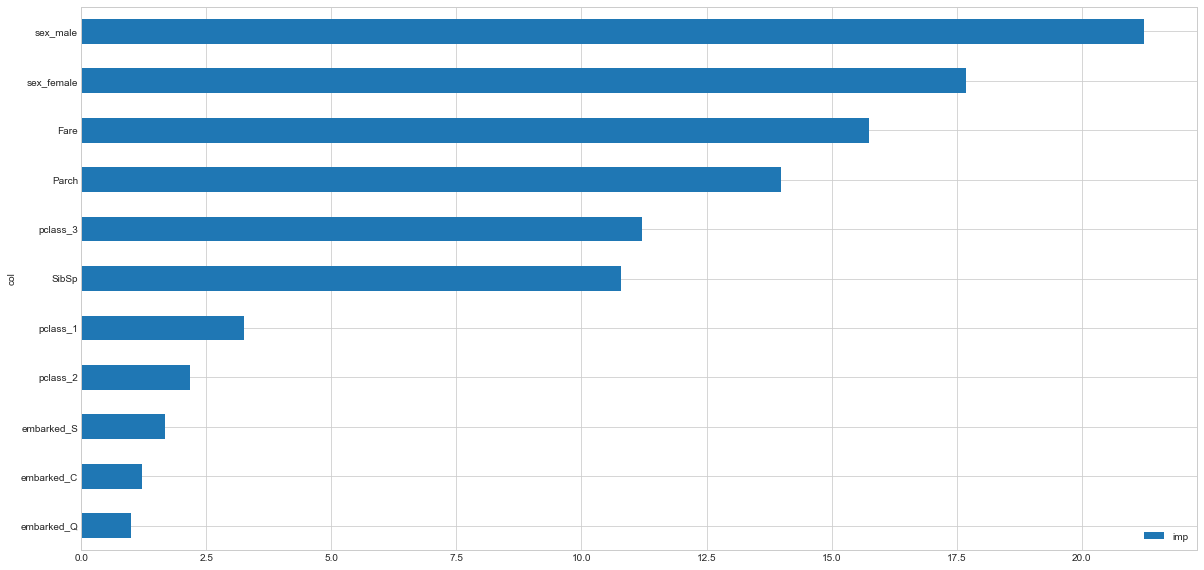

In [122]:
# Plot the feature importance scores
feature_importance(catboost_model, x_train)

## Why would you want feature importance?

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

Recall = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

Precision = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an F1 score.

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [123]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

## Submission

Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the test dateframe, encode them and make a prediciton with our model.

In [124]:
# We need our test dataframe to look like this one
x_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [125]:
# Our test dataframe has some columns our model hasn't been trained on
test.head().transpose()

,0,1,2,3,4
PassengerId,892,893,894,895,896
Pclass,3,3,2,3,3
Name,"Kelly, Mr. James","Wilkes, Mrs. James (Ellen Needs)","Myles, Mr. Thomas Francis","Wirz, Mr. Albert","Hirvonen, Mrs. Alexander (Helga E Lindqvist)"
Sex,male,female,male,male,female
Age,34.5,47.0,62.0,27.0,22.0
SibSp,0,1,0,0,1
Parch,0,0,0,0,1
Ticket,330911,363272,240276,315154,3101298
Fare,7.8292,7.0,9.6875,8.6625,12.2875
Cabin,NaN,NaN,NaN,NaN,NaN


In [126]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [127]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [128]:
# Let's look at test, it should have one hot encoded columns now
test.head().transpose()

,0,1,2,3,4
PassengerId,892,893,894,895,896
Pclass,3,3,2,3,3
Name,"Kelly, Mr. James","Wilkes, Mrs. James (Ellen Needs)","Myles, Mr. Thomas Francis","Wirz, Mr. Albert","Hirvonen, Mrs. Alexander (Helga E Lindqvist)"
Sex,male,female,male,male,female
Age,34.5,47.0,62.0,27.0,22.0
SibSp,0,1,0,0,1
Parch,0,0,0,0,1
Ticket,330911,363272,240276,315154,3101298
Fare,7.8292,7.0,9.6875,8.6625,12.2875
Cabin,NaN,NaN,NaN,NaN,NaN


The columns in test have been converted to the same format at df_con_enc. Now we can make predictions on the test dataframe columns we built a model on.

We can find the columns we made predictions on with x_train.columns.

In [129]:
# Create a list of columns to be used for the predictions
wanted_test_columns = x_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [130]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns]
                                    .apply(LabelEncoder().fit_transform))

In [131]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
      dtype=int64)

In [132]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [133]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [134]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [135]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('../catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [136]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


Now submit your .csv to Kaggle!

https://www.kaggle.com/c/titanic/submit